In [ ]:
""" VERSION 05 - GENERATE N-HOPS (max 3) PLUS TIDY UP OF CODE - 6-MAY-2021 Carol Paipa

- VERSION 04 - CREATING WEIGHT FEATURES FOR DATA MODEL - 3-MAY-2021 
- VERSION 03 - GROUPING AUTHOR-1, AUTHOR-2 PAIRINGS, AND WEIGHT (COUNT) HOW MANY TIMES COAUTHORED TOGETHER - 28-APR-2021
- VERSION 02 - ...
- VERSION 01 - CREATING NODES, EDGES, NETWORK GRAPH

SINA CO-AUTHOR NETWORK GRAPH ANALYSIS 

Code for generating Nodes/Edges list for Co-Authors from Dimensions Dataset

Source data: Dimensions Published Papers for Profession Zhang between 2011 and 2021

1. Load in Dimensions Data Set
2. Split out Co-Authors per Paper
   - Assign Author ID for unique Author by Name
3. Generate Node list of unique Authors
4. Generate Edges list for Co-Author pairs - all Co-Authors are linked to each other
   - links between Papers will be based on unique Author names
"""
""" NEW FEATURES FOR MODEL WE COULD CONSIDER:
- coauthorship period - recent (0-2 yrs), medium (2-5 yrs), decade-10 (5-10 yrs), decade-20 (10-20 yrs), decade-20-plus (over 20 yrs)
- group size - solo (1), pair (2), group-small (3-5), group-med (5-10), group-large (10-20), group-xlarge (20-100), group-giant (100+)
- topic (of the paper) - limit to finite list in the data
- paper frequency of an author - the more times an author appears linked to papers, the more likely they are to colaborate
"""

In [1013]:
# Load pandas
!pip install wordcloud
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns            
%matplotlib inline 
sns.set(color_codes=True)
import timeit

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.preprocessing import StandardScaler, Normalizer, normalize

# regular expression package for removing punctuation from text
import re

# which folders host all the python files
import sys

In [13]:
#-----------------------------------------------------------------------------
# Load in the Citations data
#-----------------------------------------------------------------------------
# doc_dv = 'Dimensions-Publication-2021-03-15_09-30-48.csv'
doc_dv = 'Dimensions-Publication-2021-04-18_09-17-17.csv'

data = pd.read_csv(doc_dv, skiprows=1, low_memory=False)
print(data.info())

# cleanup unwanted rows & columns
df_data = data.copy()
print('n-rows    = ', len(df_data),'(before filtering)')

# exclude rows where ID not begin with 'pub.'
df_data = df_data[df_data['Publication ID'].str.contains('pub.') == True]

# remove most columns exception for 'Publication ID', 'Cited references'
n = len(df_data.columns)
print('n-columns = ',n)
print('n-rows    = ', len(df_data),'(after filtering)','\n')

# only keep meaningful columns - not "unamed"
df_data.drop(df_data.iloc[:, 15:n], inplace = True, axis = 1) 
print(df_data.columns.tolist(),'\n')

# clean up rows where Times Cited is not a number
df_data_fix = df_data.copy()
df_data['len_cited'] = [len(str(x)) for x in df_data['Times cited']]
print(df_data.head(3))

print('len(df_data)',len(df_data))
df_data = df_data.dropna(subset=['Times cited'])
print('len(df_data)',len(df_data))

df_data = df_data[df_data['len_cited']<=3]
# print(df_data)

# convert Times cited to number
df_data['Fix'] = [int(x) for x in df_data['Times cited']]
columns=['Times cited']
df_data.drop(columns,axis=1,inplace=True)

# rename fixed column, back to Times cited
df_data = df_data.rename(columns={'Fix':'Times cited'})
print(df_data.info())                    

# Extract only the useful dimensions
df_data = df_data[['Publication ID','Title','Abstract','Authors','Authors Affiliations - Name of Research organization','Times cited','Cited references','PubYear']].copy()
df_data.columns = ['Publication ID','Title','Abstract','Authors','Authors Affiliations','Times Cited','Cited references','Pub Year']
df_data.head(3)

csv_file = 'Dimensions-Publication_small.csv'
df_data.to_csv(csv_file)
print('df_data                     ',df_data.shape)

#-----------------------------------------------------------------------------
# Extract out individual Authors, Affiliations, Cited references - from lists
#-----------------------------------------------------------------------------
# df_citat['Authors'][1]
# eg: 'Molin, Nicole L.; Molin, Clifford; Dalpatadu, Rohan J.; Singh, Ashok K.'

df_pub = df_data[['Publication ID','Authors','Authors Affiliations','Cited references','Times Cited','Pub Year']].copy()

df_pub.to_csv('df_published.csv')

# Replace NaN with a ';' - will delete these later stage
df_pub['Authors_2'] = df_pub['Authors'].fillna(';')
df_pub['Authors Affiliations_2'] = df_pub['Authors Affiliations'].fillna(';')
df_pub['Cited references_2'] = df_pub['Cited references'].fillna(';')
print('with additional fix columns ',df_pub.shape)
df_pub

# rename our fixed columns back to the original ones
df_pub = df_pub.drop(columns=(['Authors','Authors Affiliations','Cited references']))
df_pub.columns=(['Publication ID','Times Cited','Pub Year','Authors','Authors Affiliations','Cited references'])
print('after fix columns removed   ',df_pub.shape)

# Remove junk author to avoid count/sorting fail
pub_list = ['pub.1134802587','pub.1134588066']
df_pub[~df_pub['Publication ID'].isin(pub_list)]

# some test publications during development
pub_list_in = ['pub.1129598070','pub.1129601032','pub.1135906085','pub.1136271880']
#df_pub = df_pub[df_pub['Publication ID'].isin(pub_list_in)]

# extract sample rows for development only
sample_rows=5000
df_pub = df_pub[0:sample_rows]
print('test rows during development',df_pub.shape)

df_pub = df_pub.reset_index()
df_pub

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 15 columns):
Publication ID                                             2454 non-null object
DOI                                                        2414 non-null object
Title                                                      2454 non-null object
Abstract                                                   1907 non-null object
Source title/Anthology title                               2453 non-null object
PubYear                                                    2454 non-null int64
Volume                                                     2344 non-null object
Issue                                                      2062 non-null object
Pagination                                                 2299 non-null object
Authors                                                    2454 non-null object
Authors Affiliations - Name of Research organization       1969 non-null object
Authors Affili

,index,Publication ID,Times Cited,Pub Year,Authors,Authors Affiliations,Cited references
0,0,pub.1135650611,0,2021,"Suel, Esra; Bhatt, Samir; Brauer, Michael; Fla...",Imperial College London; ETH Zurich; Universit...,"[Yue, Jun; Zhao, Wenzhi; Mao, Shanjun; Liu, Hu..."
1,1,pub.1136928512,0,2021,"Anenberg, Susan; Mohegh, Arash; Goldberg, Dani...",George Washington University; University of Br...,"[Perez, Laura; Lurmann, Fred; Wilson, John; Pa..."
2,2,pub.1136892376,0,2021,"Stieb, David M; Evans, Greg J; To, Teresa M; L...",Health Canada; University of Ottawa; Universit...,;
3,3,pub.1136866794,0,2021,"Bowe, Benjamin; Gibson, Andrew K.; Xie, Yan; Y...",Saint Louis University; Washington University ...,"[Crouse, Dan L.; Philip, Sajeev; van Donkelaar..."
4,4,pub.1133731628,1,2021,"Abera, Asmamaw; Friberg, Johan; Isaxon, Christ...",Addis Ababa University; Lund University; Unive...,"[Rehfuess, E A; Tzala, L; Best, N; Briggs, D J..."
...,...,...,...,...,...,...,...
2429,2449,pub.1030592224,0,1983,"Pope, C. Arden; Heady, Earl O.",Texas A&M University,;
2430,2450,pub.1060056001,1,1983,"KREWSKI, D.; CRUMP, K.S.; FARMER, J.; GAYLOR, ...",;,;
2431,2451,pub.1069862033,0,1982,"Iachan, Ronaldo; Krewski, D.; Platek, R.; Rao,...",;,;
2432,2452,pub.1064407837,160,1981,"Krewski, D.; Rao, J. N. K.",;,;


## Create wide-column table with each individual author per column (col heading is author-index)
### Each Paper pub.ID is one row, each column to the right of "# Authors" is one author

In [14]:
#----------------------------------------------------
# Extract individual strings from list - Authors
#----------------------------------------------------
df_pub['Authors_Split'] = [list(x.split('; ')) for x in df_pub['Authors']]
df_pub.head()

# df_test['Authors_Split'].iloc[2]
df_split = df_pub[['index','Publication ID','Times Cited','Pub Year','Authors_Split']].copy()
df_split

# how many co-authors for each paper
df_split['# Authors'] = [len(x) for x in df_split['Authors_Split']]
df_split.sort_values('# Authors', ascending=False)
df_split

# Dataframe just of Pub-ID with Index 0-N rows NOTE: if adding new columns before # Authors - add +1 (per new column) to col_index
col_index = 6
df_paper = pd.DataFrame(df_split.iloc[:,:col_index])   #.values.tolist())  #.reset_index()
# temp name for index column
df_paper['index_pub'] = df_paper['index']
df_paper = df_paper[['index','index_pub','Publication ID','Times Cited','Pub Year','Authors_Split','# Authors']]
df_paper

# Dataframe just of Authors but converted to columns (across)
df_auth = df_split[['index','Authors_Split']].copy()
df_auth_cols = df_auth.iloc[:,1].apply(pd.Series).reset_index()  
df_auth_cols

# Concat (join) dataframes based on Index (hopefully they match original Pub-ID and Author rows)
df_new = pd.concat([df_paper, df_auth_cols], axis=1)
df_new = df_new.fillna('')

# remove both index columns
df_new.drop(df_new.iloc[:,:1], inplace = True, axis = 1)
df_new = df_new.rename(columns={'index_pub':'index'})
df_new

,index,Publication ID,Times Cited,Pub Year,Authors_Split,# Authors,0,1,2,3,...,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211
0,0,pub.1135650611,0,2021,"[Suel, Esra, Bhatt, Samir, Brauer, Michael, Fl...",5,"Suel, Esra","Bhatt, Samir","Brauer, Michael","Flaxman, Seth",...,,,,,,,,,,
1,1,pub.1136928512,0,2021,"[Anenberg, Susan, Mohegh, Arash, Goldberg, Dan...",8,"Anenberg, Susan","Mohegh, Arash","Goldberg, Daniel L.","Brauer, Michael",...,,,,,,,,,,
2,2,pub.1136892376,0,2021,"[Stieb, David M, Evans, Greg J, To, Teresa M, ...",10,"Stieb, David M","Evans, Greg J","To, Teresa M","Lakey, Pascale S J",...,,,,,,,,,,
3,3,pub.1136866794,0,2021,"[Bowe, Benjamin, Gibson, Andrew K., Xie, Yan, ...",7,"Bowe, Benjamin","Gibson, Andrew K.","Xie, Yan","Yan, Yan",...,,,,,,,,,,
4,4,pub.1133731628,1,2021,"[Abera, Asmamaw, Friberg, Johan, Isaxon, Chris...",8,"Abera, Asmamaw","Friberg, Johan","Isaxon, Christina","Jerrett, Michael",...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,2449,pub.1030592224,0,1983,"[Pope, C. Arden, Heady, Earl O.]",2,"Pope, C. Arden","Heady, Earl O.",,,...,,,,,,,,,,
2430,2450,pub.1060056001,1,1983,"[KREWSKI, D., CRUMP, K.S., FARMER, J., GAYLOR,...",9,"KREWSKI, D.","CRUMP, K.S.","FARMER, J.","GAYLOR, D.W.",...,,,,,,,,,,
2431,2451,pub.1069862033,0,1982,"[Iachan, Ronaldo, Krewski, D., Platek, R., Rao...",4,"Iachan, Ronaldo","Krewski, D.","Platek, R.","Rao, J. N. K.",...,,,,,,,,,,
2432,2452,pub.1064407837,160,1981,"[Krewski, D., Rao, J. N. K.]",2,"Krewski, D.","Rao, J. N. K.",,,...,,,,,,,,,,


## Create long-row table now with each Paper + Author as one row
#### - one row is paper pub.id + one author
#### - papers with multiple co-authors will appear multiple (row) times
eg: paper pub.1109780440 has 1212 authors => so will results in 1212 rows

In [29]:
#------------------------------------------------------
# iterate across all author columns, append them after each other, final concat for all appended dataframes
#------------------------------------------------------
# create Pub-ID column name so can link back to original data
col_list = list(df_new.columns.values)
col_list

print('authors col_list = ',col_list[5],'-',col_list[len(col_list)-1])
col_end = col_list[len(col_list)-1]

# iterate across all author columns
all_auth = []
new_list = ['index','Publication ID','Times Cited','Pub Year','Authors_Split','# Authors','Author']
for col in col_list[col_index:]:
    df_app = []
    df_app = df_new[['index','Publication ID','Times Cited','Pub Year','Authors_Split','# Authors',col]].copy()
    df_app.columns = new_list
    all_auth.append(df_app)

# concatenated all appended Author (wide) columns into 1 single column
df_pub_auth = pd.concat(all_auth)
print('len pub-auth all rows         ',df_pub_auth.shape)

# remove rows with blank Authors
df_pub_auth = df_pub_auth[df_pub_auth['Author']!='']  
df_pub_auth = df_pub_auth[df_pub_auth['Author']!=';']  
print('len pub-auth del blank Authors',df_pub_auth.shape)

# save output Published Papers - each Author linked to paper
df_pub_auth.to_csv('df_pub_authors.csv')
df_pub_auth

authors col_list =  # Authors - 1211
len pub-auth all rows          (2950008, 7)
len pub-auth del blank Authors (37052, 7)


,index,Publication ID,Times Cited,Pub Year,Authors_Split,# Authors,Author
0,0,pub.1135650611,0,2021,"[Suel, Esra, Bhatt, Samir, Brauer, Michael, Fl...",5,"Suel, Esra"
1,1,pub.1136928512,0,2021,"[Anenberg, Susan, Mohegh, Arash, Goldberg, Dan...",8,"Anenberg, Susan"
2,2,pub.1136892376,0,2021,"[Stieb, David M, Evans, Greg J, To, Teresa M, ...",10,"Stieb, David M"
3,3,pub.1136866794,0,2021,"[Bowe, Benjamin, Gibson, Andrew K., Xie, Yan, ...",7,"Bowe, Benjamin"
4,4,pub.1133731628,1,2021,"[Abera, Asmamaw, Friberg, Johan, Isaxon, Chris...",8,"Abera, Asmamaw"
...,...,...,...,...,...,...,...
375,376,pub.1109780440,159,2018,"[Collaborators, GBD 2017 SDG, Lozano, Rafael, ...",1212,"Zoeckler, Leo"
375,376,pub.1109780440,159,2018,"[Collaborators, GBD 2017 SDG, Lozano, Rafael, ...",1212,"Zucker, Inbar"
375,376,pub.1109780440,159,2018,"[Collaborators, GBD 2017 SDG, Lozano, Rafael, ...",1212,"Zuhlke, Liesel Joanna J"
375,376,pub.1109780440,159,2018,"[Collaborators, GBD 2017 SDG, Lozano, Rafael, ...",1212,"Lim, Stephen S"


### CREATE "Author" nodes - assume Author with same name is the same Author - may not be true in real life

#### - node_id will be unique per author name, and becomes the author-index later on
#### - size_author is the number of papers that authors name can be linked to
#### Some authors have full names, or lastname + initial - but for now, we will treat them as 2 authors


In [1082]:
#-----------------------------------------------------------
# create Author nodes - assume Author with same name
# is the same Author - may not be true in real life
#-----------------------------------------------------------

df_node_author = df_pub_auth.copy()
df_node_author = df_node_author[['index','Author']].groupby('Author').count().reset_index().reset_index()
df_node_author.columns=(['index_author','Author','Author Total Papers'])
df_node_author

# combine Published-Author + Author-ID to link Paper-ID and Author-ID
df_pub_auth_count = df_pub_auth.join(df_node_author.set_index('Author'), on='Author')
df_pub_auth_count

#-------------------------------------------------------
# finish creating nodes for each Author (unique by name)
df_node_author['node_group']='author'
df_node_author.columns=(['node_id','node_name','size_author','node_group'])
df_node_author

#-------------------------------------------------------
# check rows are the same - start of Pub list, end of Author list - matching above lists
nodes = df_node_author[['node_id','node_name','node_group','size_author']]
nodes.to_csv('df_pub_auth_nodes.csv')

print(f'      Number of individual authors = {len(nodes)}')

nodes.sort_values('size_author', ascending=False).head(5)

      Number of individual authors = 13099


,node_id,node_name,node_group,size_author
6146,6146,"Krewski, Daniel",author,419
1524,1524,"Brauer, Michael",author,385
5410,5410,"Jerrett, Michael",author,307
7376,7376,"Martin, Randall V.",author,167
1610,1610,"Brook, Jeffrey R.",author,165


### Top 10 Authors linked to published papers - these are prolific researchers

#### Could be a feature - the more times an author is linked to a new paper - the more likely they are to colaborate

In [23]:
#df_p = pd.DataFrame(df_auth.pivot_table(index=['Author'], aggfunc='size')).reset_index().reset_index()
#df_p.columns = ['index','Author','count']

x_lab = 'node_name'
y_lab = 'size_author'

# set limit to show on x-axis
size_min = 45
clrs = ['#3498db'] 

df_p = nodes.copy()
df_p = df_p[df_p[y_lab]>=size_min].sort_values('size_author', ascending=False)
print("Top 10 mentioned authors")
print('df_p:',df_p.sort_values('size_author', ascending=False).head(10))

Top 10 mentioned authors
df_p:        node_id             node_name node_group  size_author
6146      6146       Krewski, Daniel     author          419
1524      1524       Brauer, Michael     author          385
5410      5410      Jerrett, Michael     author          307
7376      7376    Martin, Randall V.     author          167
1610      1610     Brook, Jeffrey R.     author          165
13028    13028  van Donkelaar, Aaron     author          161
5162      5162         Hystad, Perry     author          144
1718      1718   Burnett, Richard T.     author          138
4198      4198     Goldberg, Mark S.     author          126
11917    11917   Villeneuve, Paul J.     author          119


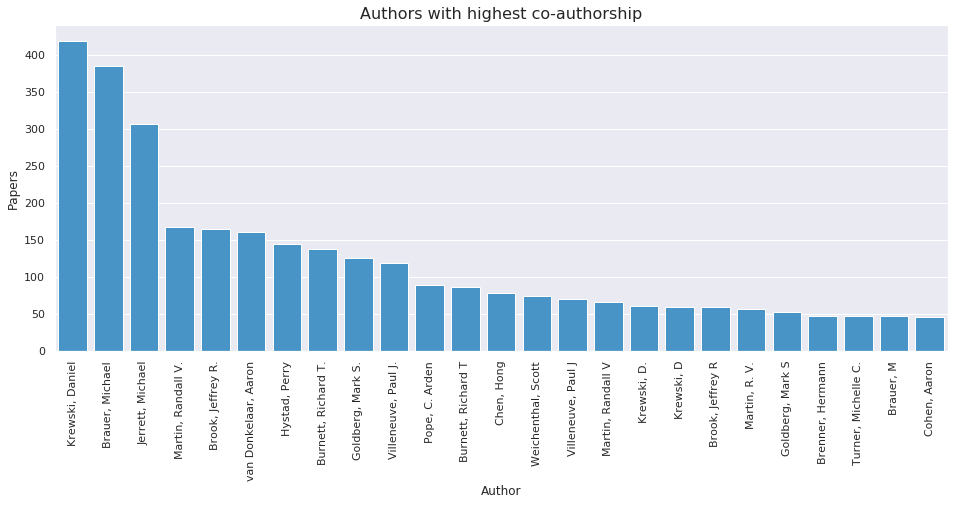

In [7]:
# Visualise number of papers an author is linked to
#-----------------------------------------------------------------

fig = plt.figure(figsize=(16, 6))   
ax = sns.barplot(data=df_p, x=x_lab, y=y_lab, order=df_p[x_lab], palette=sns.color_palette(clrs, 10))

#ax.set(ylim=(0, 125))
ax.set_title('Authors with highest co-authorship', fontsize=16)
plt.xlabel('Author')
plt.ylabel('Papers')
plt.rcParams["figure.figsize"] = (10,3)
plt.xticks(rotation='vertical')
#plt.xticks([])
#plt.yticks([])
plt.show();

### Which papers have the most number of co-authors
#### - 2 papers over 1000 co-authors
#### - 30 approx with over 200 co-authors
These co-author sizes add great complexity to our data model

In [24]:
#-----------------------------------------------------------------
# Visualise number of co-authors per paper - limit number of papers for graph
#-----------------------------------------------------------------

#df_p = pd.DataFrame(df_auth.pivot_table(index=['Author'], aggfunc='size')).reset_index().reset_index()
#df_p.columns = ['index','Author','count']

x_lab = 'Publication ID'
y_lab = '# Authors'
# set limit to show on x-axis
size_min = 100
clrs = ['#3498db'] 

df_pa = df_pub_auth[['Publication ID','# Authors']].copy()
df_pa = df_pa[df_pa[y_lab]>=size_min].groupby(['Publication ID','# Authors']).count().reset_index().sort_values('# Authors', ascending=False)

print('Top 10 papers with number of authors (total papers):',len(df_pa))
df_pa.sort_values('# Authors', ascending=False).head(5)

Top 10 papers with number of authors (total papers): 56


,Publication ID,# Authors
36,pub.1109780440,1212
51,pub.1131781786,1031
50,pub.1131774541,941
3,pub.1007496904,909
53,pub.1131794493,866


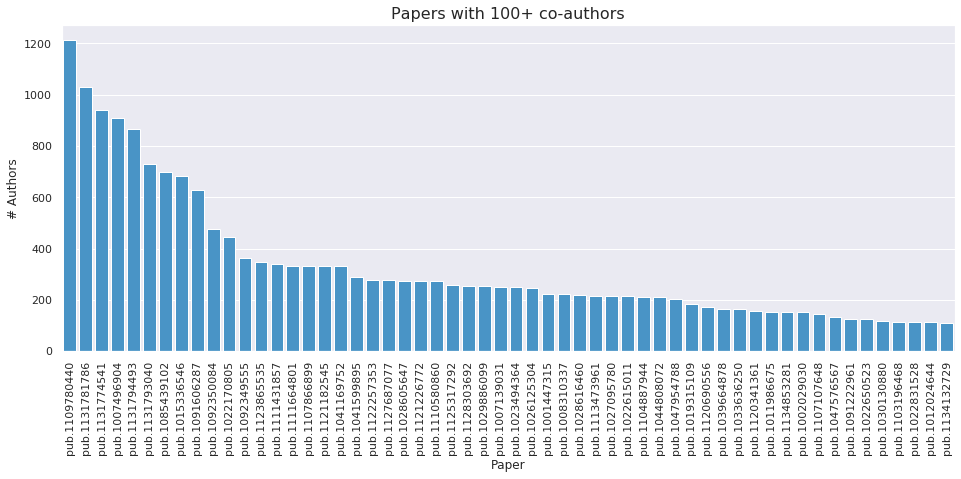

In [64]:
fig = plt.figure(figsize=(16, 6))   
ax = sns.barplot(data=df_pa, x=x_lab, y=y_lab, order=df_pa[x_lab], palette=sns.color_palette(clrs, 10))

#ax.set(ylim=(0, 125))
ax.set_title('Papers with 100+ co-authors', fontsize=16)
plt.xlabel('Paper')
plt.ylabel('# Authors')
plt.rcParams["figure.figsize"] = (10,3)
plt.xticks(rotation='vertical')
#plt.xticks([])
#plt.yticks([])
plt.show();

## Create Co-Author Relationships for Network Graph
Each Co-Author of a Paper is linked to each other - like a Clique (sub-network)

In [1083]:
#---------------------------------------------------------------
# LIMIT PAPERS CO-AUTHOR SIZE - JUST DURING DEVELOPMENT
# Number of papers with max 5 authors: 3541  
# (max 5 = 3541 rows, max 10 = 10624 rows, max 100 = 18640 rows)
#---------------------------------------------------------------
max_coauthor = 5

df_pub_auth_subset = df_pub_auth_count[df_pub_auth_count['# Authors']<=max_coauthor].copy()

print(f'\nNumber of papers with max {max_coauthor} authors:',len(df_pub_auth_subset),'\n')

# data for Published Paper ID linked to Co-Author ID's
df_pub_auth_subset


Number of papers with max 5 authors: 3541 



,index,Publication ID,Times Cited,Pub Year,Authors_Split,# Authors,Author,index_author,Author Total Papers
0,0,pub.1135650611,0,2021,"[Suel, Esra, Bhatt, Samir, Brauer, Michael, Fl...",5,"Suel, Esra",11038,1
6,6,pub.1136718356,0,2021,"[Ru, M., Brauer, M., Lamarque, J‐F., Shindell,...",4,"Ru, M.",9822,1
11,11,pub.1136420830,0,2021,"[Hosford, Kate, Firth, Caislin, Brauer, Michae...",4,"Hosford, Kate",5018,2
12,12,pub.1136335024,0,2021,"[Shairsingh, Kerolyn K, Brook, Jeffrey R, Mihe...",4,"Shairsingh, Kerolyn K",10371,1
13,13,pub.1136257028,0,2021,"[Hudson-Hanley, Barbara, Smit, Ellen, Branscum...",5,"Hudson-Hanley, Barbara",5101,1
...,...,...,...,...,...,...,...,...,...
2363,2383,pub.1028279752,22,1991,"[Mayo, N E, Goldberg, M S, Levy, A R, Danys, I...",5,"Korner-Bitensky, N",6091,2
2371,2391,pub.1003749438,0,1991,"[Krewski, D., Bickis, M., Gaylor, D., Colin, D...",5,"Szyszkowicz, M.",11124,3
2382,2402,pub.1005726202,2,1990,"[Krewski, D., Siemiatycki, J., Nadon, L., Dewa...",5,"Gérin, M.",4457,2
2385,2405,pub.1042510220,28,1989,"[Gérin, Michel, Siemiatycki, Jack, Nadon, Loui...",5,"Krewski, Daniel",6146,419


## Check one author - by name - all papers linked to this author name
#### Within or max numer of co-authors per paper
#### During testing only

In [1084]:
""" VALIDATING DATA ONLY - NOT FOR FULL PROCESS """

""" change this author name, if you want to view a different authors list of papers """
# drill down into selected author - by name
select_author_name = 'Brauer, Michael'   #'Pope, C. Arden'

# get published papers "index" linked to an author "index_author"
pub_list = df_pub_auth_subset[df_pub_auth_subset['Author']==select_author_name]['index'].unique().tolist()

# author name from node file (so only 1 instance)
print(f'Published papers ({len(df_pub_auth_subset[df_pub_auth_subset["Author"]==select_author_name])}) linked to author -',nodes[nodes['node_name']==select_author_name]['node_name'],'\n')

# show all papers linked to selected author
df_pub_auth_subset[df_pub_auth_subset['Author']==select_author_name]

Published papers (149) linked to author - 1524    Brauer, Michael
Name: node_name, dtype: object 



,index,Publication ID,Times Cited,Pub Year,Authors_Split,# Authors,Author,index_author,Author Total Papers
29,29,pub.1134933033,0,2021,"[Brauer, Michael, Casadei, Barbara, Harrington...",5,"Brauer, Michael",1524,385
86,86,pub.1130702056,0,2020,"[Brauer, Michael, Zhao, Jeff T, Bennitt, Fiona...",4,"Brauer, Michael",1524,385
115,115,pub.1128529945,5,2020,"[Brauer, Michael, Zhao, Jeff T, Bennitt, Fiona...",4,"Brauer, Michael",1524,385
134,134,pub.1127649554,28,2020,"[Brauer, Michael, Zhao, Jeff T, Bennitt, Fiona...",4,"Brauer, Michael",1524,385
144,144,pub.1126590327,5,2020,"[Brauer, Michael, Zhao, Jeff T, Bennitt, Fiona...",4,"Brauer, Michael",1524,385
...,...,...,...,...,...,...,...,...,...
1371,1382,pub.1049901153,80,2010,"[Carlsten, Chris, Dybuncio, Anne, Becker, Alla...",5,"Brauer, Michael",1524,385
1427,1440,pub.1071046579,82,2010,"[Winters, Meghan, Teschke, Kay, Grant, Michael...",5,"Brauer, Michael",1524,385
1605,1619,pub.1034830174,44,2008,"[Hystad, Perry U, Setton, Eleanor M, Allen, Ry...",5,"Brauer, Michael",1524,385
1875,1890,pub.1047349784,35,2005,"[Smargiassi, Audrey, Baldwin, Mary, Pilger, Ch...",5,"Brauer, Michael",1524,385


## Check one author - by Index No - all papers linked to this author index
#### Within or max numer of co-authors per paper
#### During testing only

In [1085]:
""" VALIDATING DATA ONLY - NOT FOR FULL PROCESS """

""" change this index number, if you want to view a different authors list of papers """
# drill down into selected author - by index number
select_author_index = 10944    

# get published papers "index" linked to an author "index_author"
pub_list = df_pub_auth_count[df_pub_auth_count['index_author']==select_author_index]['index'].unique().tolist()

# author name from node file (so only 1 instance)
print(f'Published papers ({len(df_pub_auth_count[df_pub_auth_count["index_author"]==select_author_index])}) linked to author -',nodes[nodes['node_id']==select_author_index]['node_name'],'\n')

# show all papers linked to selected author
df_pub_auth_count[df_pub_auth_count['index_author']==select_author_index]

Published papers (14) linked to author - 10944    Stieb, David M
Name: node_name, dtype: object 



,index,Publication ID,Times Cited,Pub Year,Authors_Split,# Authors,Author,index_author,Author Total Papers
2,2,pub.1136892376,0,2021,"[Stieb, David M, Evans, Greg J, To, Teresa M, ...",10,"Stieb, David M",10944,14
43,43,pub.1134078292,0,2020,"[Stieb, David M, Evans, Greg J, To, Teresa M, ...",5,"Stieb, David M",10944,14
88,88,pub.1130332642,8,2020,"[Stieb, David M, Evans, Greg J, To, Teresa M, ...",5,"Stieb, David M",10944,14
1668,1682,pub.1011333405,14,2007,"[Stieb, David M, Evans, Gregory J, Sabaliauska...",8,"Stieb, David M",10944,14
1849,1864,pub.1036690893,37,2005,"[Stieb, David M, Doiron, Marc Smith, Blagden, ...",4,"Stieb, David M",10944,14
1928,1943,pub.1001722369,0,2004,"[Stieb, David M, Krupnick, Alan J, Adamowicz, ...",6,"Stieb, David M",10944,14
455,456,pub.1105982177,26,2018,"[Lavigne, Éric, Burnett, Richard T, Stieb, Dav...",8,"Stieb, David M",10944,14
1968,1984,pub.1031058114,177,2003,"[Gilbert, Nicolas L, Woodhouse, Sandy, Stieb, ...",4,"Stieb, David M",10944,14
18,18,pub.1135997077,0,2021,"[Lavigne, Éric, Talarico, Robert, van Donkelaa...",10,"Stieb, David M",10944,14
1029,1036,pub.1031124279,25,2013,"[Chen, Li, Villeneuve, Paul J, Rowe, Brian H, ...",5,"Stieb, David M",10944,14


## CREATE AUTHOR-PAIRS for each published paper
### A1, A2 combination
#### Using sample authors during development until logic is confirmed

In [1087]:
# 3541 rows where max 5 co-authors on a paper
len(df_pub_auth_subset)

# 1528 unique authors in df_pub_auth_subset step
len(df_pub_auth_subset['index_author'].unique().tolist())

# create list of unqiue authors in "max # co-authors" sample 
sample_author = df_pub_auth_subset['index_author'].unique().tolist()

print(f'Sample of unique authors in papers with max {max_coauthor} co-authors => total {len(sample_author)} authors\n\n',sample_author[0:50])
print('\nSample last 10 authors =', sample_author[-10:-1])

Sample of unique authors in papers with max 5 co-authors => total 1528 authors

 [11038, 9822, 5018, 10371, 5101, 3916, 4197, 4368, 1524, 11916, 1609, 4586, 12151, 10944, 6838, 9918, 12379, 9199, 2474, 12378, 8956, 6424, 2349, 11917, 2475, 1716, 11637, 5651, 5162, 9841, 3026, 989, 6307, 591, 8997, 12718, 12536, 9201, 10859, 6427, 6608, 7073, 7068, 3225, 8693, 9884, 1228, 12150, 8715, 12670]

Sample last 10 authors = [7029, 9172, 7731, 3145, 8931, 7706, 9366, 4595, 6091]


In [692]:
#--------------------------------------------------------------------------
# following code inspired by DVN week 8 lab - Song Similarity Network Graph
#--------------------------------------------------------------------------
starttime = timeit.default_timer()

""" drill down into selected author - while building graph so not too many to blow out memory """
""" SAMPLE DURING DEVELOPMENT """
#others eg: select_author_index = [10944,1717]  select_author_index = [1524,12848,6146,2161]
select_author_index = sample_author

# Get all unique Published Paper ID's based on selected authors "isin(select_author_index)"
pub_list = df_pub_auth_subset[df_pub_auth_subset['index_author'].isin(select_author_index)]['index'].unique().tolist()

print('Papers Pub ID (sample)            => ',pub_list[0:20])
print('Unique published papers list (count) :',len(pub_list), '  <= approx. number of columns wide in modelling data')

# pub_list[0:500] = Total time is : 12.44 seconds / 0.21 minutes
# pub_list = pub_list[0:500]
# print('# of Publications (sample) ',len(pub_list),'\n')

# Subsetting
def subtable(df, productName):
    return (df[(df['index'] == productName)])

all_pairs = []
df_pairs = pd.DataFrame()

# iterate through list of published papers + each co-author
i = 0
for pub in pub_list:
    auth_pairs = []
    # get all co-authors 
    df_subset = subtable(df_pub_auth_subset.copy(), pub)
    # create indicies for each co-author in paper
    auth_indicies = df_subset['index_author'].values.tolist()
    pub_year = df_subset['Pub Year'][0:1].tolist()
    # link all co-author indicies as pairs to each other
    if len (auth_indicies)>1:
        auth_pairs = pd.DataFrame(list(itertools.combinations(auth_indicies, 2)))
        auth_pairs['pub_year'] = pub_year[0]
        all_pairs.append(auth_pairs)
        df_pairs = pd.concat(all_pairs, sort=True)
    i += 1

print('Iterations for auth-pairs            :', i)

# EDGE WEIGHT is number of papers author-pairs are linked to, eg: A1,A2 weight = 3, will be 3 rows, means 3 papers
# auth_pairs rows repeat each time per paper they are co-authors in
# 6146	2161
# 6146	2161
# 6146	2161
# This pair - edge weight is 3

# count number of times pairs have worked together - also group by year
df_pairs = df_pairs.groupby([0,1,'pub_year']).size()\
    .sort_values(ascending=False)\
    .reset_index(name='weight')\
    .drop_duplicates(subset=1)

print('Final pairs co-authors for each Published Paper')
df_pairs.columns = ['author-1','author-2','pub_year','weight']

# create auth-pair "tuple" (just a string for now) - add pub_year so the pairing & year published is unique
df_pairs['auth-pair'] = df_pairs['author-1'].astype(str).str.cat(df_pairs['author-2'].astype(str), sep=',').str.cat(df_pairs['pub_year'].astype(str), sep=',')

# JUST FOR TESTING - BASED ON ORIGINAL 2 AUTH-PAIRS [10944,1717]
pair_list = df_pairs['author-1'].unique().tolist() + df_pairs['author-2'].unique().tolist()
pair_list = pd.DataFrame(sample_author)[0].unique().tolist()

print("Number of auth-pair rows             :", len(df_pairs))
print("Unique authors in auth-pair list     :", len(pair_list),'\n')

if (timeit.default_timer() - starttime) > 60:
    print('Total time is                              : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes\n')

print('    sample pairing of co-authors, weight is the number of papers they co-author together')
df_pairs  #.head(10)

Papers Pub ID (sample)            =>  [0, 6, 11, 12, 13, 20, 24, 26, 29, 32, 34, 38, 41, 43, 44, 48, 51, 72, 82, 83]
Unique published papers list (count) : 979   <= approx. number of columns wide in modelling data
Iterations for auth-pairs            : 500
Final pairs co-authors for each Published Paper
Number of auth-pair rows             : 644
Unique authors in auth-pair list     : 1528 

    sample pairing of co-authors, weight is the number of papers they co-author together


,author-1,author-2,pub_year,weight,auth-pair
0,6146,11700,2010,18,"6146,11700,2010"
1,11700,6146,2010,7,"11700,6146,2010"
2,1610,2863,2011,6,"1610,2863,2011"
4,4882,1610,2011,5,"4882,1610,2011"
7,1111,10874,2020,4,"1111,10874,2020"
...,...,...,...,...,...
2680,7915,8773,2010,1,"7915,8773,2010"
2690,7616,11649,2008,1,"7616,11649,2008"
2704,7915,2374,2016,1,"7915,2374,2016"
2706,7844,3687,2012,1,"7844,3687,2012"


In [1090]:
#--------------------------------------------------------------------------
# following code inspired by DVN week 8 lab - Song Similarity Network Graph
#--------------------------------------------------------------------------
starttime = timeit.default_timer()

""" drill down into selected author - while building graph so not too many to blow out memory """
""" SAMPLE DURING DEVELOPMENT """
#others eg: select_author_index = [10944,1717]  select_author_index = [1524,12848,6146,2161]
select_author_index = sample_author

# Get all unique Published Paper ID's based on selected authors "isin(select_author_index)"
pub_list = df_pub_auth_subset[df_pub_auth_subset['index_author'].isin(select_author_index)]['index'].unique().tolist()

# Testing only
# pub_list[0:500] = Total time is : 12.44 seconds / 0.21 minutes
# pub_list = pub_list[0:500]

print('Papers Pub ID (sample)            => ',pub_list[0:20])
print('Unique published papers list (count) :',len(pub_list), '  <= approx. number of columns wide in modelling data')

#--------------------------------------------------------------------------------
# Subsetting
def subtable(df, productName):
    return (df[(df['index'] == productName)])

all_pairs = []
df_pairs = pd.DataFrame()

# iterate through list of published papers + each co-author
i = 0
for pub in pub_list:
    auth_pairs = []
    # get all co-authors 
    df_subset = subtable(df_pub_auth_subset.copy(), pub)
    # create indicies for each co-author in paper
    auth_indicies = df_subset['index_author'].values.tolist()
    pub_year = df_subset['Pub Year'][0:1].tolist()
    # link all co-author indicies as pairs to each other
    if len (auth_indicies)>1:
        auth_pairs = pd.DataFrame(list(itertools.combinations(auth_indicies, 2)))
        auth_pairs['pub_year'] = pub_year[0]
        all_pairs.append(auth_pairs)
        df_pairs = pd.concat(all_pairs, sort=True)
    i += 1

#--------------------------------------------------------------------------------
# EDGE WEIGHT is number of papers author-pairs are linked to, eg: A1,A2 weight = 3, will be 3 rows, means 3 papers
# auth_pairs rows repeat each time per paper they are co-authors in
# 6146	2161
# 6146	2161
# 6146	2161
# This pair - edge weight is 3

print('Iterations for auth-pairs            :', i)

# count number of times pairs have worked together - also group by year
df_pairs = df_pairs.groupby([0,1,'pub_year']).size()\
    .sort_values(ascending=False)\
    .reset_index(name='weight')\
    .drop_duplicates(subset=1)

print('\nFinal pairs co-authors for each Published Paper')
df_pairs.columns = ['author-1','author-2','pub_year','weight']

# create auth-pair "tuple" (just a string for now) - add pub_year so the pairing & year published is unique
df_pairs['auth-pair'] = df_pairs['author-1'].astype(str).str.cat(df_pairs['author-2'].astype(str), sep=',').str.cat(df_pairs['pub_year'].astype(str), sep=',')

# JUST FOR TESTING - BASED ON ORIGINAL 2 AUTH-PAIRS [10944,1717]
pair_list = df_pairs['author-1'].unique().tolist() + df_pairs['author-2'].unique().tolist()
pair_list = pd.DataFrame(sample_author)[0].unique().tolist()

print("Number of auth-pair rows             :", len(df_pairs))
print("Unique authors in auth-pair list     :", len(pair_list),'\n')

#if (timeit.default_timer() - starttime) > 60:
print('Time taken is                        : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes\n')

print('      sample pairing of co-authors & publish year, weight is the number of papers they co-author together')
df_pairs 

Papers Pub ID (sample)            =>  [0, 6, 11, 12, 13, 20, 24, 26, 29, 32, 34, 38, 41, 43, 44, 48, 51, 72, 82, 83]
Unique published papers list (count) : 979   <= approx. number of columns wide in modelling data
Iterations for auth-pairs            : 979

Final pairs co-authors for each Published Paper
Number of auth-pair rows             : 1171
Unique authors in auth-pair list     : 1528 

Time taken is                        : 29.72 seconds / 0.50 minutes

    sample pairing of co-authors, weight is the number of papers they co-author together


,author-1,author-2,pub_year,weight,auth-pair
0,6146,11700,2010,18,"6146,11700,2010"
1,11700,6146,2010,7,"11700,6146,2010"
2,1610,2863,2011,6,"1610,2863,2011"
3,4882,1610,2011,5,"4882,1610,2011"
7,12848,1111,2020,4,"12848,1111,2020"
...,...,...,...,...,...
4768,7915,2374,2016,1,"7915,2374,2016"
4772,7915,8773,2010,1,"7915,8773,2010"
4779,7956,12463,1999,1,"7956,12463,1999"
4781,7852,11674,2005,1,"7852,11674,2005"


## FIND OUT how many times author-pairs are linked to a paper

In [1091]:
# sample of one author index - all linked author-2
sel_index = 1524   # 6146, 1524
len(df_pairs[df_pairs['author-1']==sel_index]['author-2'])
len(df_pairs[df_pairs['author-1']==sel_index]['author-2'].unique().tolist())

print(f"Author {sel_index} is linked to: {len(df_pairs[df_pairs['author-1']==sel_index]['author-2'].unique().tolist())} authors")
test = df_pairs[df_pairs['author-1']==sel_index].sort_values('author-2', ascending=False)
test.to_csv('df_comments.csv')
test

Author 1524 is linked to: 49 authors


,author-1,author-2,pub_year,weight,auth-pair
1619,1524,12992,2003,1,"1524,12992,2003"
1600,1524,12921,2019,1,"1524,12921,2019"
31,1524,12848,2020,4,"1524,12848,2020"
144,1524,12726,2016,2,"1524,12726,2016"
1579,1524,12440,1989,1,"1524,12440,1989"
101,1524,12408,2018,2,"1524,12408,2018"
1575,1524,12292,2004,1,"1524,12292,2004"
1573,1524,12291,2003,1,"1524,12291,2003"
148,1524,11492,2016,2,"1524,11492,2016"
1572,1524,11375,2016,1,"1524,11375,2016"


In [1094]:
# FIND HOW MANY TIMES - PAIR (A1, A2) & (A2, A1) are linked, ie: multiple paper co-authorship

# sample_author = [1524, 12848]
sample_author = df_pub_auth_subset['index_author'].unique().tolist()

# copy of subset data
df_pub_rep = df_pub_auth_subset[['index','Publication ID','Pub Year','index_author','Author']].copy()
len(df_pub_rep)

# only papers of any authors linked as auth-pairs 
df_pub_rep_pub = df_pub_rep[df_pub_rep['index_author'].isin(sample_author)].copy()
len(df_pub_rep_pub)
print('      sample authors: ', sample_author[0:50],'\n')

# show all publications where A1 or A2 are linked - some A1 & A2 are not linked through these papers
print(f'      All papers authors are linked to - regardless of A1, A2 links = {len(df_pub_rep_pub)} papers')
df_pub_rep_pub.sort_values('Publication ID')[0:10]

      sample authors:  [11038, 9822, 5018, 10371, 5101, 3916, 4197, 4368, 1524, 11916, 1609, 4586, 12151, 10944, 6838, 9918, 12379, 9199, 2474, 12378, 8956, 6424, 2349, 11917, 2475, 1716, 11637, 5651, 5162, 9841, 3026, 989, 6307, 591, 8997, 12718, 12536, 9201, 10859, 6427, 6608, 7073, 7068, 3225, 8693, 9884, 1228, 12150, 8715, 12670] 

      All papers authors are linked to - regardless of A1, A2 links = 3541 papers


,index,Publication ID,Pub Year,index_author,Author
1985,2001,pub.1000009542,2003,1726,"Burrows, William R"
1985,2001,pub.1000009542,2003,1609,"Brook, Jeffrey R"
1985,2001,pub.1000009542,2003,11735,"Urquizo, Natty"
1985,2001,pub.1000009542,2003,12037,"Walmsley, John L"
1972,1988,pub.1000018034,2003,12812,"Zhang, Leiming"


## Only publications where both authors are on that paper

In [1095]:
# only pulications where both authors are on that paper
df_pub_rep_pair = df_pub_rep_pub.groupby('Publication ID').count().reset_index()

auth_pair_count_papers = len(df_pub_rep_pair)
print('Total papers auth-pair are linked:', auth_pair_count_papers)

df_pub_rep_pair = df_pub_rep_pair['Publication ID'].unique().tolist()
print('len(df_pub_rep_pair)             :', len(df_pub_rep_pair), '\nSample only:\n', df_pub_rep_pair[0:20])

Total papers auth-pair are linked: 979
len(df_pub_rep_pair)             : 979 
Sample only:
 ['pub.1000009542', 'pub.1000018034', 'pub.1000102971', 'pub.1000428611', 'pub.1000602843', 'pub.1000651854', 'pub.1000863842', 'pub.1000882121', 'pub.1000930219', 'pub.1001005453', 'pub.1001045676', 'pub.1001049051', 'pub.1001078136', 'pub.1001270819', 'pub.1001323210', 'pub.1001383167', 'pub.1001403896', 'pub.1001904963', 'pub.1002007431', 'pub.1002109787']


In [1120]:
# initially some A1,A2 pairs, have alternative A2,A2 pair weights (counts linked papers) with same year
# this is resolved in the matching code below, eg: total weight A1, A2 = 25
# ACTUALLY NOT SURE IF RESOLVED - MAY NEED TO REMOVE DUPLICATES LATER
auth_test = ['6146,11700,2010','11700,6146,2010','1524,12848,2020','12848,1524,2020']
df_pairs[df_pairs['auth-pair'].isin(auth_test)]

,author-1,author-2,pub_year,weight,auth-pair
0,6146,11700,2010,18,"6146,11700,2010"
1,11700,6146,2010,7,"11700,6146,2010"
31,1524,12848,2020,4,"1524,12848,2020"


## Generate correct edge weight Author-1, Author-2
### Actual number of papers 2 authors have colaborated on, including Publish Year

In [1118]:
starttime = timeit.default_timer()

# df_iter = df_pairs.head(5)

# new df_pairs "fixed" dataframe
df_pairs_fix = pd.DataFrame()

# auth_select = [6852,10464]
for index, row in df_pairs.iterrows():
    #print('Iterate:',row['author-1'], ',', row['author-2'], '- weight:', row['weight'])
    auth_select = (row['author-1'], row['author-2'])
    #print('auth_select: ', auth_select)
    
    # split published papers with A1 & A2 into 2 data frames - then join into 1 row
    df_pub_rep_1a = df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author']==auth_select[0])]
    df_pub_rep_1a = df_pub_rep_1a[['index','Publication ID','Pub Year','index_author']]
    #print(df_pub_rep_1a)

    df_pub_rep_1b = df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author']==auth_select[1])]
    df_pub_rep_1b = df_pub_rep_1b[['index','Publication ID','Pub Year','index_author']]
    #print(df_pub_rep_1b)

    # join A1, A2 dataframes, remove duplicated columns "_y"
    df_pub_rep_ab = df_pub_rep_1a.join(df_pub_rep_1b, how='inner', rsuffix="_y").drop(columns=['Pub Year_y','index_y','Publication ID_y'])
    df_pub_rep_ab.columns = ('index','Publication ID','Pub Year','author-1','author-2')

    # create counter for aggregation step
    df_pub_rep_ab['count'] = 1

    # aggregate authors & pub-year - count number of co-author rows
    df_pair_count = df_pub_rep_ab.groupby(['author-1','author-2','Pub Year']).agg({'index':'count'}).reset_index()
    df_pair_count.columns = ['author-1','author-2','Pub Year','weight']
    df_pair_count['auth-pair-str'] = df_pair_count['author-1'].astype(str).str.cat(df_pair_count['author-2'].astype(str).str.cat(df_pair_count['Pub Year'].astype(str), sep=',') , sep=',')
    # create list of author-1, author-2, pub-year - we need list, not string, for indexing next step
    df_pair_count['auth-pair'] = [[x,y,z] for x,y,z in zip(df_pair_count['author-1'],df_pair_count['author-2'],df_pair_count['Pub Year'])]
   
    df_pairs_fix = pd.concat([df_pairs_fix, df_pair_count], ignore_index=True)  

if (timeit.default_timer() - starttime) > 0:
    print('\nTotal time is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes')

print('\nAuthor pairs weight correct to actual # papers co-authored')
df_pairs_fix


Total time is : 20.21 seconds / 0.34 minutes

Author pairs weight correct to actual # papers co-authored


,author-1,author-2,Pub Year,weight,auth-pair-str,auth-pair
0,6146,11700,2008,1,"6146,11700,2008","[6146, 11700, 2008]"
1,6146,11700,2010,25,"6146,11700,2010","[6146, 11700, 2010]"
2,11700,6146,2008,1,"11700,6146,2008","[11700, 6146, 2008]"
3,11700,6146,2010,25,"11700,6146,2010","[11700, 6146, 2010]"
4,1610,2863,2011,6,"1610,2863,2011","[1610, 2863, 2011]"
...,...,...,...,...,...,...
1382,7915,2374,2016,1,"7915,2374,2016","[7915, 2374, 2016]"
1383,7915,8773,2010,1,"7915,8773,2010","[7915, 8773, 2010]"
1384,7956,12463,1999,1,"7956,12463,1999","[7956, 12463, 1999]"
1385,7852,11674,2005,1,"7852,11674,2005","[7852, 11674, 2005]"


In [1121]:
# initially some A1,A2 pairs, have alternative A2,A2 pair weights (counts linked papers) with same year
# this is resolved in the matching code below, eg: total weight A1, A2 = 25
# ACTUALLY NOT SURE IF RESOLVED - MAY NEED TO REMOVE DUPLICATES LATER

df_pairs_fix[df_pairs_fix['auth-pair-str'].isin(auth_test)]

,author-1,author-2,Pub Year,weight,auth-pair-str,auth-pair
1,6146,11700,2010,25,"6146,11700,2010","[6146, 11700, 2010]"
3,11700,6146,2010,25,"11700,6146,2010","[11700, 6146, 2010]"
17,1524,12848,2020,4,"1524,12848,2020","[1524, 12848, 2020]"


### VALIDATING AUTH-PAIRS & NUMBER OF PAPERS WORKED TOGETHER GROUPED BY YEARS
#### In order to calculate weights for 2 years, 5 years, etc...

Firstly - select one auth-pair combination, that we know have co-authored papers different years

In [1143]:
# VALIDATING AUTH-PAIRS & NUMBER OF PAPERS WORKED TOGETHER GROUPED BY YEARS
# in order to calculate weights for 2 years, 5 years, etc...

# 1524, 4814 / 12408, 1524 / 1524, 12726 / 2360, 9201 / 1524, 346
auth_test = [1524, 4814]
df_pairs_fix[(df_pairs_fix['author-1']==auth_test[0]) & (df_pairs_fix['author-2']==auth_test[1])]

,author-1,author-2,Pub Year,weight,auth-pair-str,auth-pair,weight_2_years,weight_5_years,hop_1,hop_2,hop_3
8,1524,4814,2007,1,"1524,4814,2007","[1524, 4814, 2007]",0,0,1,0,0
9,1524,4814,2009,1,"1524,4814,2009","[1524, 4814, 2009]",0,0,1,0,0
10,1524,4814,2018,4,"1524,4814,2018","[1524, 4814, 2018]",4,4,1,0,0
11,1524,4814,2019,1,"1524,4814,2019","[1524, 4814, 2019]",1,1,1,0,0


#### Pick one year from last step which you want to check if the count of those papers is correct
There are more papers that individual authors are linked to - but you can manually check in the output below, if the "worked together per year" count has worked

In [1123]:
# VALIDATING AUTH-PAIRS & NUMBER OF PAPERS WORKED TOGETHER GROUPED BY YEARS
# ACTUAL PAPERS AUTHOR/CO-AUTHOR ON
# in order to calculate weights for 2 years, 5 years, etc...

test_year = [2018]

print('     Manually verify number of papers worked together, matches above "weight"')
df_pub_rep_pub[(df_pub_rep_pub['index_author'].isin(auth_test)) & (df_pub_rep_pub['Pub Year'].isin(test_year))].sort_values(['Publication ID','Pub Year','index_author'])

     Manually verify number of papers worked together, matches above "weight"


,index,Publication ID,Pub Year,index_author,Author
493,494,pub.1101406997,2018,1524,"Brauer, Michael"
445,446,pub.1106277913,2018,1524,"Brauer, Michael"
437,438,pub.1106858244,2018,1524,"Brauer, Michael"
385,386,pub.1107819752,2018,1524,"Brauer, Michael"
385,386,pub.1107819752,2018,4814,"Henderson, Sarah B"
373,373,pub.1109898023,2018,1524,"Brauer, Michael"
369,369,pub.1110128183,2018,1524,"Brauer, Michael"
513,514,pub.1122885694,2018,1524,"Brauer, Michael"
424,425,pub.1122886280,2018,1524,"Brauer, Michael"
423,424,pub.1122886303,2018,1524,"Brauer, Michael"


## Split published papers with A1 & A2 into 2 data frames - then join into 1 row

In [1124]:
# split published papers with A1 & A2 into 2 data frames - then join into 1 row
def papers_A1_A2(df_pub_rep_pub, df_pub_rep_pair, select_author_index, print_idx):
    df_pub_rep_A1_A2 = pd.DataFrame()
    print('')
    i = 0
    for idx in select_author_index:
        i += 1
        if print_idx==True:
            print(f'idx-{i}: {idx}')
        df_pub_rep_1a = df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author']==idx[0])]
        df_pub_rep_1a = df_pub_rep_1a[['index','Publication ID','Pub Year','index_author']]
        #print('df_pub_rep_1a:',df_pub_rep_1a)

        df_pub_rep_1b = df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author']==idx[1])]
        df_pub_rep_1b = df_pub_rep_1b[['index','Publication ID','Pub Year','index_author']]
        #print('df_pub_rep_1b:',df_pub_rep_1b)

        df_pub_rep_ab = df_pub_rep_1a.join(df_pub_rep_1b, how='inner', rsuffix="_y").drop(columns=['Pub Year_y', 'index_y','Publication ID_y'])
        df_pub_rep_ab.columns = ('index','Publication ID','Pub Year','author-1','author-2')

        # create auth-pair  df_pair_count['author-1'].astype(str).str.cat(df_pair_count['author-2'].astype(str), sep=',') 
        #df_pub_rep_ab['auth-pair'] = df_pub_rep_ab['author-1'].astype(str).str.cat(df_pair_count['author-2'].astype(str), sep=',') 
        df_pub_rep_ab['count'] = 1
        df_pub_rep_A1_A2 = pd.concat([df_pub_rep_A1_A2, df_pub_rep_ab], ignore_index=True)  
        #print(df_pub_rep_A1_A2)
        
    return df_pub_rep_A1_A2

In [1125]:
#---------------------------------------------------------
# RUN FOR ALL AUTH-PAIRS & LINKED PAPERS
#---------------------------------------------------------
starttime = timeit.default_timer()

# rerun previous step but for all author pairs, not just sample
select_author_pair = df_pairs_fix['auth-pair'].tolist()

# NOTE: select_author_index must be a list of [A1,A2] lists
# ie:   [[6146, 11700], [6619, 6146], [10115, 1524], [6146, 2161], [9201, 3027]]
# TESTING
select_author_pair = select_author_pair  #[0:3]
   
print('Total author-pairs          :',len(select_author_pair))
print('select_author_index (sample):',select_author_pair[0:5])
print('df_pub_rep_pub              :',len(df_pub_rep_pub),'  <= Total papers all authors are linked to, including non-pairs')
print('df_pub_rep_pair             :',len(df_pub_rep_pair),'   <= # of papers linked to A1,A2 pairs\n')

# sample published papers
print(df_pub_rep_pair[0:8])

# generate list of papers that all A1-A2 pairs have colaborated on
df_pub_rep_ab = papers_A1_A2(df_pub_rep_pub, df_pub_rep_pair, select_author_pair, print_idx=False)

if (timeit.default_timer() - starttime) > 0:
    print('\nTotal time is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes')

print('\n      Actual paper colaborations for A1, A2 pair =', len(df_pub_rep_ab),'total linked papers')
df_pub_rep_ab

Total author-pairs          : 1387
select_author_index (sample): [[6146, 11700, 2008], [6146, 11700, 2010], [11700, 6146, 2008], [11700, 6146, 2010], [1610, 2863, 2011]]
df_pub_rep_pub              : 3541   <= Total papers all authors are linked to, including non-pairs
df_pub_rep_pair             : 979    <= # of papers linked to A1,A2 pairs

['pub.1000009542', 'pub.1000018034', 'pub.1000102971', 'pub.1000428611', 'pub.1000602843', 'pub.1000651854', 'pub.1000863842', 'pub.1000882121']


Total time is : 13.59 seconds / 0.23 minutes

      Actual paper colaborations for A1, A2 pair = 2473 total linked papers


,index,Publication ID,Pub Year,author-1,author-2,count
0,1446,pub.1067488638,2010,6146,11700,1
1,1447,pub.1067488637,2010,6146,11700,1
2,1450,pub.1067488634,2010,6146,11700,1
3,1451,pub.1067488633,2010,6146,11700,1
4,1452,pub.1067488632,2010,6146,11700,1
...,...,...,...,...,...,...
2468,765,pub.1079306231,2016,7915,2374,1
2469,1404,pub.1032940083,2010,7915,8773,1
2470,2194,pub.1074528215,1999,7956,12463,1
2471,1901,pub.1006756720,2005,7852,11674,1


## 1. Convert Author-Pairs linked Published Papers into Pivot Table
#### This step creates pivot, but has 2 levels of column headings

In [1126]:
# convert long paper-author1-author2 to pivot table - author1, author2 are first 2 columns, paper pub.id become columns also (wide)
df_piv = pd.pivot_table(df_pub_rep_ab, index=['author-1', 'author-2','Pub Year'], columns=['Publication ID'], values=['count'],fill_value=0)
df_piv.reset_index()

author-1 author-2 Pub Year          count                 \
Publication ID                            pub.1000009542 pub.1000018034   
0                     9        2     2019              0              0   
1                    12     9362     2002              0              0   
2                    16      768     2009              0              0   
3                    16     3418     2009              0              0   
4                    83     6588     2003              0              0   
...                 ...      ...      ...            ...            ...   
1382              13028     4003     2016              0              0   
1383              13028     8803     2006              0              0   
1384              13028    10848     2015              0              0   
1385              13028    12527     2014              0              0   
1386              13037     5778     2011              0              0   

                                                                            \
Publication ID pub.1000428611 pub.1000602843 pub.1000651854 pub.1000863842   
0                           0              0              0              0   
1                           0              0              0              0   
2                           0              0              0              0   
3                           0              0              0              0   
4                           0              0              0              0   
...                       ...            ...            ...            ...   
1382                        0              0              0              0   
1383                        0              0              0              1   
1384                        0              0              0              0   
1385                        0              0              0              0   
1386                        0              0              0              0   

                               ...                                \
Publication ID pub.1000882121  ... pub.1134078292 pub.1134163199   
0                           0  ...              0              0   
1                           0  ...              0              0   
2                           0  ...              0              0   
3                           0  ...              0              0   
4                           0  ...              0              0   
...                       ...  ...            ...            ...   
1382                        0  ...              0              0   
1383                        0  ...              0              0   
1384                        0  ...              0              0   
1385                        0  ...              0              0   
1386                        0  ...              0              0   

                                                                            \
Publication ID pub.1134894837 pub.1134933033 pub.1135650611 pub.1135706775   
0                           0              0              0              0   
1                           0              0              0              0   
2                           0              0              0              0   
3                           0              0              0              0   
4                           0              0              0              0   
...                       ...            ...            ...            ...   
1382                        0              0              0              0   
1383                        0              0              0              0   
1384                        0              0              0              0   
1385                        0              0              0              0   
1386                        0              0              0              0   

                                                                            
Publication ID pub.1136257028 pub.1136335024 pu

## 2. Reduce column headings to 1 level only
#### Then save results to CSV  =>  coauthor_wide_data.csv

In [1139]:
# convert pivot table with multiple levels - to 1 level - keeping paper pub.id has headings going across
df_piv_1 = df_piv.copy()
df_piv_1.columns = [col[1] for col in df_piv_1.columns]
df_piv_1 = df_piv_1.reset_index()

# save results to CSV
df_piv_1.to_csv('coauthor_wide_data.csv')
print('\nCo-author pairs & published papers (wide columns) rows,cols:',df_piv_1.shape)
print('Saved to csv  =>  coauthor_wide_data.csv','\n')

# show results here
df_piv_1.head(5)


Co-author pairs & published papers (wide columns) rows,cols: (1387, 779)
Saved to csv  =>  coauthor_wide_data.csv 



,author-1,author-2,Pub Year,pub.1000009542,pub.1000018034,pub.1000428611,pub.1000602843,pub.1000651854,pub.1000863842,pub.1000882121,...,pub.1134078292,pub.1134163199,pub.1134894837,pub.1134933033,pub.1135650611,pub.1135706775,pub.1136257028,pub.1136335024,pub.1136420830,pub.1136718356
0,9,2,2019,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12,9362,2002,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,768,2009,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16,3418,2009,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,83,6588,2003,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. CREATE FEATURES - NUMBER OF YEARS A1, A2 HAVE WORKED TOGETHER
#### Create as one-hot-encoded (OHE) columns

In [1140]:
# create OHE and feature columns

df_piv_1['num_years_past'] = [(2021 - x) for x in df_piv_1['Pub Year']]
df_piv_1['within_2_years'] = [1 if x <= 2 else 0 for x in df_piv_1['num_years_past']]
df_piv_1['within_5_years'] = [1 if x <= 5 else 0 for x in df_piv_1['num_years_past']]
df_piv_1['within_10_years'] = [1 if x <= 10 else 0 for x in df_piv_1['num_years_past']]
df_piv_1['more_than_10_years'] = [1 if x > 10 else 0 for x in df_piv_1['num_years_past']]

pub_cols = df_piv_1.columns[3:-5]
print(f' Publish paper ID heading cols length: {len(pub_cols)}\n',pub_cols)

 Publish paper ID heading cols length: 776
 Index(['pub.1000009542', 'pub.1000018034', 'pub.1000428611', 'pub.1000602843',
       'pub.1000651854', 'pub.1000863842', 'pub.1000882121', 'pub.1000930219',
       'pub.1001005453', 'pub.1001045676',
       ...
       'pub.1134078292', 'pub.1134163199', 'pub.1134894837', 'pub.1134933033',
       'pub.1135650611', 'pub.1135706775', 'pub.1136257028', 'pub.1136335024',
       'pub.1136420830', 'pub.1136718356'],
      dtype='object', length=776)


In [1141]:
# reorder pivot table created columns - newer features after author-1, author-2

auth_cols = ['author-1','author-2','Pub Year','num_years_past','within_2_years','within_5_years','within_10_years','more_than_10_years']
auth_cols.extend(pub_cols)

df_piv_1 = df_piv_1[auth_cols]
print('Data rows,cols:',(df_piv_1.shape))
df_piv_1

Data rows,cols: (1387, 784)


,author-1,author-2,Pub Year,num_years_past,within_2_years,within_5_years,within_10_years,more_than_10_years,pub.1000009542,pub.1000018034,...,pub.1134078292,pub.1134163199,pub.1134894837,pub.1134933033,pub.1135650611,pub.1135706775,pub.1136257028,pub.1136335024,pub.1136420830,pub.1136718356
0,9,2,2019,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12,9362,2002,19,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,768,2009,12,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16,3418,2009,12,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,83,6588,2003,18,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,13028,4003,2016,5,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1383,13028,8803,2006,15,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1384,13028,10848,2015,6,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1385,13028,12527,2014,7,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Create Feature columns for pre-pivot data modelling for Auth-Pairs (one per row, no more yearly row)
- all years 
- within 2 years
- within 5 years


In [1151]:
# Weight features - within 2 years, within 5 years - worked together
year_2 = 2017
year_5 = 2013
year_10 = 2011

df_pairs_fix['weight_2_years'] = [y if x >= year_2 else 0 for x, y in zip(df_pairs_fix['Pub Year'], df_pairs_fix['weight'])]
df_pairs_fix['weight_5_years'] = [y if x >= year_5 else 0 for x, y in zip(df_pairs_fix['Pub Year'], df_pairs_fix['weight'])]
df_pairs_fix['weight_10_years'] = [y if x >= year_10 else 0 for x, y in zip(df_pairs_fix['Pub Year'], df_pairs_fix['weight'])]

#df_pairs_fix['hop_1'] = 1
#df_pairs_fix['hop_2'] = 0
#df_pairs_fix['hop_3'] = 0
#df_pairs_fix = df_pairs_fix.drop(columns=['hop_1','hop_2','hop_3'])

# test one combination
auth_test = [1524,12408]
test = df_pairs_fix[(df_pairs_fix['author-1']==auth_test[0]) & (df_pairs_fix['author-2']==auth_test[1])]
test

,author-1,author-2,Pub Year,weight,auth-pair-str,auth-pair,weight_2_years,weight_5_years,weight_10_years
68,1524,12408,2010,3,"1524,12408,2010","[1524, 12408, 2010]",0,0,0
69,1524,12408,2011,1,"1524,12408,2011","[1524, 12408, 2011]",0,0,1
70,1524,12408,2013,1,"1524,12408,2013","[1524, 12408, 2013]",0,1,1
71,1524,12408,2016,2,"1524,12408,2016","[1524, 12408, 2016]",0,2,2
72,1524,12408,2018,2,"1524,12408,2018","[1524, 12408, 2018]",2,2,2
73,1524,12408,2021,1,"1524,12408,2021","[1524, 12408, 2021]",1,1,1


### Test - how does the example look after aggregating to one author-1, author-2 row only

In [1153]:
# how does the example look after aggregating to one author-1, author-2 row only
df_test_count = test.groupby(['author-1','author-2']).agg({'weight':'sum', 'weight_2_years':'sum', 'weight_5_years':'sum', 'weight_10_years':'sum'}).reset_index()
df_test_count.columns = ['author-1','author-2','weight_all_years','weight_2_years','weight_5_years','weight_10_years']
df_test_count

,author-1,author-2,weight_all_years,weight_2_years,weight_5_years,weight_10_years
0,1524,12408,10,3,6,7


In [1157]:
df_pairs_fix

,author-1,author-2,Pub Year,weight,auth-pair-str,auth-pair,weight_2_years,weight_5_years,weight_10_years
0,6146,11700,2008,1,"6146,11700,2008","[6146, 11700, 2008]",0,0,0
1,6146,11700,2010,25,"6146,11700,2010","[6146, 11700, 2010]",0,0,0
2,11700,6146,2008,1,"11700,6146,2008","[11700, 6146, 2008]",0,0,0
3,11700,6146,2010,25,"11700,6146,2010","[11700, 6146, 2010]",0,0,0
4,1610,2863,2011,6,"1610,2863,2011","[1610, 2863, 2011]",0,0,6
...,...,...,...,...,...,...,...,...,...
1382,7915,2374,2016,1,"7915,2374,2016","[7915, 2374, 2016]",0,1,1
1383,7915,8773,2010,1,"7915,8773,2010","[7915, 8773, 2010]",0,0,0
1384,7956,12463,1999,1,"7956,12463,1999","[7956, 12463, 1999]",0,0,0
1385,7852,11674,2005,1,"7852,11674,2005","[7852, 11674, 2005]",0,0,0


### Repeat aggregation step for all auth-pair rows - A1,A2 pairing should be unique

In [1158]:
# repeat aggregation step for all auth-pair rows - A1,A2 pairing should be unique
df_pairs_weight = df_pairs_fix.groupby(['author-1','author-2']).agg({'weight':'sum', 'weight_2_years':'sum', 'weight_5_years':'sum', 'weight_10_years':'sum'}).reset_index()

# recreate auth-pair index now, without the year
df_pairs_weight['auth-pair'] = df_pairs_weight['author-1'].astype(str).str.cat(df_pairs_weight['author-2'].astype(str), sep=',')

# create a reverse auth-pair combination - in case the pairing is A2,A1 reversed
df_pairs_weight['auth-pair-rev'] = df_pairs_weight['author-2'].astype(str).str.cat(df_pairs_weight['author-1'].astype(str), sep=',')

# final column names
df_pairs_weight.columns = ['author-1','author-2','weight_all_years','weight_2_years','weight_5_years','weight_10_years','auth-pair','auth-pair-rev']

print('     Number of unique A1,A1 pair rows:',len(df_pairs_weight['auth-pair'].unique().tolist()))
df_pairs_weight

     Number of unique A1,A1 pair rows: 1171


,author-1,author-2,weight_all_years,weight_2_years,weight_5_years,weight_10_years,auth-pair,auth-pair-rev
0,9,2,1,1,1,1,"9,2","2,9"
1,12,9362,1,0,0,0,"12,9362","9362,12"
2,16,768,1,0,0,0,"16,768","768,16"
3,16,3418,1,0,0,0,"16,3418","3418,16"
4,83,6588,2,0,0,0,"83,6588","6588,83"
...,...,...,...,...,...,...,...,...
1166,13028,4003,1,0,1,1,"13028,4003","4003,13028"
1167,13028,8803,1,0,0,0,"13028,8803","8803,13028"
1168,13028,10848,1,0,1,1,"13028,10848","10848,13028"
1169,13028,12527,1,0,1,1,"13028,12527","12527,13028"


### CHECK for any A1,A2 and A2,A1 duplications

In [1159]:
# checking if A1,A2 - repeats in reverse as A2,A1
auth_1 = 12408
auth_2 = 11336
df_pairs_weight[(df_pairs_weight['author-1']==auth_1) & (df_pairs_weight['author-2']==auth_2)]

,author-1,author-2,weight_all_years,weight_2_years,weight_5_years,weight_10_years,auth-pair,auth-pair-rev
1130,12408,11336,5,0,3,3,"12408,11336","11336,12408"


In [1160]:
# it does not appear so (repeating in reverse)
df_pairs_weight[(df_pairs_weight['author-1']==auth_2) & (df_pairs_weight['author-2']==auth_1)]

,author-1,author-2,weight_all_years,weight_2_years,weight_5_years,weight_10_years,auth-pair,auth-pair-rev


In [1161]:
auth_1 = 10336
auth_2 = 12408
all_authors_paired[(all_authors_paired['author-1']==auth_1) & (all_authors_paired['author-2']==auth_2)]

,author-1,author-2,auth-pair,auth-pair-rev


In [1162]:
all_authors_paired[(all_authors_paired['author-1']==auth_2) & (all_authors_paired['author-2']==auth_1)]

,author-1,author-2,auth-pair,auth-pair-rev
194406,12408,10336,"12408,10336","10336,12408"


### GENERATE ALL AUTHOR PAIRINGS - A1,A2
#### Regardless of linked A1,A2 data above - we need total pairings for ALL authors

In [1164]:
# PAIR ALL AUTHORS IN OUR DATA - 1528 unique authors = 1,166,628 (A1, A2) author-pairings 
print(f'Total unique authors in papers with max {max_coauthor} co-authors =>',len(sample_author))
print(f'Number of (A1,A2) co-authors combinations by paper   => {len(df_pairs_weight)}')

# link all A1, A2 author pair combinations
all_authors_paired = pd.DataFrame(list(itertools.combinations(sample_author, 2)))
all_authors_paired.columns = ['author-1','author-2']
all_authors_paired['auth-pair'] = all_authors_paired['author-1'].astype(str).str.cat(all_authors_paired['author-2'].astype(str), sep=',')
all_authors_paired['auth-pair-rev'] = all_authors_paired['author-2'].astype(str).str.cat(all_authors_paired['author-1'].astype(str), sep=',')

print(f'Creates total rows for (A1,A2) pair combinations     => {len(all_authors_paired)} \n')
all_authors_paired

Total unique authors in papers with max 5 co-authors => 1528
Number of (A1,A2) co-authors combinations by paper   => 1171
Creates total rows for (A1,A2) pair combinations     => 1166628 



,author-1,author-2,auth-pair,auth-pair-rev
0,11038,9822,"11038,9822","9822,11038"
1,11038,5018,"11038,5018","5018,11038"
2,11038,10371,"11038,10371","10371,11038"
3,11038,5101,"11038,5101","5101,11038"
4,11038,3916,"11038,3916","3916,11038"
...,...,...,...,...
1166623,9366,6091,"9366,6091","6091,9366"
1166624,9366,4457,"9366,4457","4457,9366"
1166625,4595,6091,"4595,6091","6091,4595"
1166626,4595,4457,"4595,4457","4457,4595"


### MATCH ALL AUTHOR-PAIRS TO OUR LINKED AUTHOR-PAIRS in previous steps
#### 3 STEPS REQUIRED:
- A1, A2 all authors
- A2, A1 (in case no match other way around)
- combine step 1 & 2

In [1174]:
# MATCH ALL AUTHOR-PAIRS TO OUR LINKED AUTHOR-PAIRS in previous steps
# 3 STEPS REQUIRED:
# - A1, A2
# - A2, A1 (in case no match other way around)
# - combine step 1 & 2

auth_pair_step_1 = sorted(df_pairs_weight['auth-pair'].unique().tolist())
auth_pair_step_2 = sorted(df_pairs_weight['auth-pair-rev'].unique().tolist())
print('Total defined auth-pairs:',len(auth_pair_step_1))

df_step_1 = all_authors_paired[all_authors_paired['auth-pair'].isin(auth_pair_step_1)]['auth-pair'].unique().tolist()
df_step_2 = all_authors_paired[all_authors_paired['auth-pair'].isin(auth_pair_step_2)]['auth-pair'].unique().tolist()

print(f'Auth-pairs step 1 = {len(df_step_1)}, step 2 = {len(df_step_2)}, total rows = {len(df_step_1)+len(df_step_2)}','\n\nStep 1 auth-pairs:')
print(df_step_1[0:50])

print('\nStep 2 auth-pairs:\n',df_step_2)

Total defined auth-pairs: 1171
Auth-pairs step 1 = 1073, step 2 = 98, total rows = 1171 

Step 1 auth-pairs:
['11038,1211', '5018,3625', '5101,10693', '5101,1517', '5101,5904', '3916,2388', '3916,9189', '4197,8189', '4197,10557', '4197,4598', '4197,6471', '4197,12274', '4368,12572', '4368,12809', '1524,12408', '1524,2358', '1524,4814', '1524,10825', '1524,1952', '1524,12848', '1524,12726', '1524,7244', '1524,9609', '1524,8481', '1524,5798', '1524,0', '1524,9018', '1524,9953', '1524,4912', '1524,5800', '1524,943', '1524,6118', '1524,4637', '1524,2719', '1524,6411', '1524,9385', '1524,1917', '1524,5990', '1524,7452', '1524,5361', '1524,4008', '1524,12992', '1524,12291', '1524,9559', '1524,10004', '1524,5745', '1524,12440', '1524,3651', '1524,3826', '1524,10874']

Step 2 auth-pairs:
 ['4197,7471', '1524,8297', '11916,1164', '1609,11498', '10944,4105', '9199,3026', '6424,3182', '11917,6468', '1716,3839', '11637,4983', '6307,4198', '9201,3757', '6608,1593', '8693,7063', '1228,1542', '3019,1

### Step 1 - A1,A2 data from df_pairs_weight

In [1177]:
# Step 1 - A1,A2 data from df_pairs_weight
df_step_1_pairs = df_pairs_weight[df_pairs_weight['auth-pair'].isin(df_step_1)][['author-1','author-2','weight_all_years','weight_2_years','weight_5_years','weight_10_years','auth-pair']]
df_step_1_pairs.columns = ['author-1','author-2','weight_all_years','weight_2_years','weight_5_years','weight_10_years','auth-pair']
print('total step 1 rows: ',len(df_step_1_pairs))
df_step_1_pairs

total step 1 rows:  1073


,author-1,author-2,weight_all_years,weight_2_years,weight_5_years,weight_10_years,auth-pair
0,9,2,1,1,1,1,"9,2"
1,12,9362,1,0,0,0,"12,9362"
2,16,768,1,0,0,0,"16,768"
3,16,3418,1,0,0,0,"16,3418"
4,83,6588,2,0,0,0,"83,6588"
...,...,...,...,...,...,...,...
1166,13028,4003,1,0,1,1,"13028,4003"
1167,13028,8803,1,0,0,0,"13028,8803"
1168,13028,10848,1,0,1,1,"13028,10848"
1169,13028,12527,1,0,1,1,"13028,12527"


### Step 2 - the A1,A2 is in reverse order, so need to rename auth-pair-rev, to auth-pair

In [1178]:
# Step 2 - the A1,A2 is in reverse order, so need to rename auth-pair-rev, to auth-pair
df_step_2_pairs = df_pairs_weight[df_pairs_weight['auth-pair-rev'].isin(df_step_2)][['author-1','author-2','weight_all_years','weight_2_years','weight_5_years','weight_10_years','auth-pair-rev']]
df_step_2_pairs.columns = ['author-1','author-2','weight_all_years','weight_2_years','weight_5_years','weight_10_years','auth-pair']

print('total step 2 rows: ',len(df_step_2_pairs))
df_step_2_pairs[0:10]

total step 2 rows:  98


,author-1,author-2,weight_all_years,weight_2_years,weight_5_years,weight_10_years,auth-pair
12,187,7772,2,0,0,0,"7772,187"
28,346,426,1,0,0,1,"426,346"
36,452,266,1,0,0,0,"266,452"
47,561,12338,2,0,0,0,"12338,561"
50,645,12902,3,0,0,0,"12902,645"
55,776,5576,1,0,0,0,"5576,776"
60,940,5794,2,0,0,0,"5794,940"
66,946,9423,1,0,0,0,"9423,946"
73,1164,2867,3,0,3,3,"2867,1164"
74,1164,3019,3,1,3,3,"3019,1164"


### Combine steps 1 & 2 into 1 dataset - now the auth-pair order matches the all_authors_paired listing

In [1181]:
# combine steps 1 & 2 into 1 dataset - but the auth-pair order matches the all_authors_paired listing
df_step_3_pairs = pd.concat([df_step_1_pairs, df_step_2_pairs])

print('total step 3 rows: ',len(df_step_3_pairs))
df_step_3_pairs

total step 3 rows:  1171


,author-1,author-2,weight_all_years,weight_2_years,weight_5_years,weight_10_years,auth-pair
0,9,2,1,1,1,1,"9,2"
1,12,9362,1,0,0,0,"12,9362"
2,16,768,1,0,0,0,"16,768"
3,16,3418,1,0,0,0,"16,3418"
4,83,6588,2,0,0,0,"83,6588"
...,...,...,...,...,...,...,...
1104,11983,4198,2,0,2,2,"4198,11983"
1108,12038,11735,2,0,0,0,"11735,12038"
1130,12408,11336,5,0,3,3,"11336,12408"
1131,12415,447,1,0,0,0,"447,12415"


### Join step 3 (combined 1 and 2) with full all_authors_paired - with duplicates removed
#### Many NAN values appear in sample data - ignore, just means these are not yet 1 to 1 linked
#### This is almost the final data for the Machine Learning models - we just need N_Hop below

In [1182]:
# join step 3 (combined 1 and 2) with full all_authors_paired - with duplicates removed
all_authors_merge = all_authors_paired.merge(df_step_3_pairs, how='left', on='auth-pair', suffixes=('','_y')).drop(columns=['author-1_y','author-2_y'])
all_authors_merge = all_authors_merge.drop_duplicates()
all_authors_merge

,author-1,author-2,auth-pair,auth-pair-rev,weight_all_years,weight_2_years,weight_5_years,weight_10_years
0,11038,9822,"11038,9822","9822,11038",NaN,NaN,NaN,NaN
1,11038,5018,"11038,5018","5018,11038",NaN,NaN,NaN,NaN
2,11038,10371,"11038,10371","10371,11038",NaN,NaN,NaN,NaN
3,11038,5101,"11038,5101","5101,11038",NaN,NaN,NaN,NaN
4,11038,3916,"11038,3916","3916,11038",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1166634,9366,6091,"9366,6091","6091,9366",NaN,NaN,NaN,NaN
1166635,9366,4457,"9366,4457","4457,9366",NaN,NaN,NaN,NaN
1166636,4595,6091,"4595,6091","6091,4595",NaN,NaN,NaN,NaN
1166637,4595,4457,"4595,4457","4457,4595",NaN,NaN,NaN,NaN


In [1184]:
# view some all_authors_merge that are linked 1 to 1
auth_test = [331]
auth_test = ['1524,12408','331,5674','11336,12408','9201,2360','12536,10115']
all_authors_merge[(all_authors_merge['auth-pair'].isin(auth_test))][['auth-pair','author-1','author-2','weight_all_years','weight_2_years','weight_5_years','weight_10_years']]

,auth-pair,author-1,author-2,weight_all_years,weight_2_years,weight_5_years,weight_10_years
12312,"1524,12408",1524,12408,10.0,3.0,6.0,7.0
54421,"12536,10115",12536,10115,3.0,2.0,3.0,3.0
56273,"9201,2360",9201,2360,NaN,NaN,NaN,NaN
152058,"11336,12408",11336,12408,5.0,0.0,3.0,3.0
225220,"331,5674",331,5674,NaN,NaN,NaN,NaN


## FINDING N-HOP NODES - max 3 hops
#### Use nx.single_source_shortest_path_length() specifying cutoff=2 (2 N-hops)

https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.unweighted.single_source_shortest_path_length.html

#### Example code first - just to understand how nx.single_source_shortest_path_length() works - it returns a Dict() type

All G.nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Node (0) 1-hop nodes =>  {0: 0, 1: 1, 2: 1}
Node (4) 2-hop nodes =>  {4: 0, 1: 1, 9: 1, 10: 1, 0: 2, 3: 2}


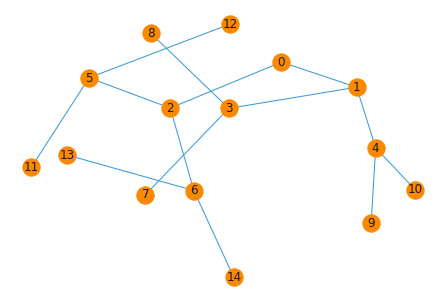

In [1186]:
""" EXAMPLE FINDING N-HOP NODES FROM SOURCE NODE """
""" nx.single_source_shortest_path_length        """
# https://groups.google.com/g/networkx-discuss/c/SQOfFq5BBJw?pli=1
import networkx as nx

G_demo=nx.balanced_tree(2,3) # binary tree rooted at node 0

nx.shortest_path_length(G_demo,source=1)

options = {
    'edge_color': clr_edge,
    'node_color': clr_node,
    'with_labels': True,
    'font_weight': 'regular'
}

# draw actual graphs
nx.draw(G_demo, pos=nx.spring_layout(G_demo, k=1, iterations=50, seed=42), **options)

[n for n,d in nx.shortest_path_length(G_demo,source=0).items() if d==2]

print('All G.nodes =',G_demo.nodes)

#If you have a large graph and only want nodes that are close to your
#source you can use the single_source_shortest_path() function and
#specify a cutoff:

# Test 1 node 0
n_hop_max = 1
source_node = 0
node_hop = nx.single_source_shortest_path_length(G_demo, source_node, cutoff=n_hop_max)
print(f'Node ({source_node}) {n_hop_max}-hop nodes => ', node_hop)

# Test 1 node 4 - returns Dict() type with all linked nodes up to cutoff (ie: max n_hop)
n_hop_max = 2
source_node = 4
node_hop = nx.single_source_shortest_path_length(G_demo, source_node, cutoff=n_hop_max)
print(f'Node ({source_node}) {n_hop_max}-hop nodes => ', node_hop)

#### Example 1 - cutoff=2 - what are the linked nodes up to 2 hops, for source node 0

In [1187]:
newdict = nx.single_source_shortest_path_length(G_demo, 0, cutoff=2)
# returns {0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2}
print(newdict)
print('dict keys   =',[*newdict])
print('dict values =',[*newdict.values()])

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2}
dict keys   = [0, 1, 2, 3, 4, 5, 6]
dict values = [0, 1, 1, 2, 2, 2, 2]


#### Example 2 - cutoff=3 - what are the linked nodes up to 3 hops, for source node 9

In [1188]:
newdict = nx.single_source_shortest_path_length(G_demo, 9, cutoff=3)
print('dict shortest path length =',newdict)
print('dict keys   =',[*newdict])
print('dict values =',[*newdict.values()])

dict shortest path length = {9: 0, 4: 1, 1: 2, 10: 2}
dict keys   = [9, 4, 1, 10]
dict values = [0, 1, 2, 2]


## PREPARE Citations Graph Data
### Create Nodes (Authors), and Edges (A1, A2, weight)
#### Save to output files for easy viewing

In [1189]:
#--------------------------------------------------------------------------
# output nodes & edges for import to Network Graph Analysis tools
#--------------------------------------------------------------------------
starttime = timeit.default_timer()

# 13099 nodes
nodes = df_node_author[['node_id','node_name','node_group','size_author']].copy()
nodes['author-1'] = nodes['node_id']

print('\nlist of pairs "nodes" sample [0:100]')
# pair_list = df_pairs['author-1'].unique().tolist()
print(pair_list[0:100])
node_pairs = nodes[nodes['author-1'].isin(pair_list)]

#--------------------------------------------------------------------------
# NODES (AUTHORS)
print('\ncoauthor_nodes rows: ', len(node_pairs))
#nodes.to_csv('coauthor_nodes.csv', index=0)
node_pairs.to_csv('coauthor_nodes.csv', index=0)

#--------------------------------------------------------------------------
# EDGES (NUMBER OF TIMES CO-AUTHOR ON PAPERS)
print('coauthor_edges rows: ', len(df_pairs))
df_pairs.to_csv('coauthor_edges.csv', index=0)

if (timeit.default_timer() - starttime)>60:
    print('\nTotal time is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes\n')

print('\n   Co-author pairs, weight = number of papers they co-author')
df_pairs[(df_pairs['author-1'].isin(select_author_index)) | (df_pairs['author-2'].isin(select_author_index))]


list of pairs "nodes" sample [0:100]
[11038, 9822, 5018, 10371, 5101, 3916, 4197, 4368, 1524, 11916, 1609, 4586, 12151, 10944, 6838, 9918, 12379, 9199, 2474, 12378, 8956, 6424, 2349, 11917, 2475, 1716, 11637, 5651, 5162, 9841, 3026, 989, 6307, 591, 8997, 12718, 12536, 9201, 10859, 6427, 6608, 7073, 7068, 3225, 8693, 9884, 1228, 12150, 8715, 12670, 5846, 12698, 108, 3926, 3019, 8345, 6456, 11025, 4292, 4983, 13028, 9842, 10372, 4480, 12187, 4004, 2564, 2377, 7273, 6468, 12609, 1611, 3035, 10318, 8429, 4982, 10533, 12524, 9844, 12610, 4907, 536, 6318, 5410, 1991, 6699, 4904, 12520, 2595, 8875, 1734, 10534, 12215, 1080, 6423, 4956, 9843, 8283, 9735, 9298]

coauthor_nodes rows:  1528
coauthor_edges rows:  1171

   Co-author pairs, weight = number of papers they co-author


,author-1,author-2,pub_year,weight,auth-pair
0,6146,11700,2010,18,"6146,11700,2010"
1,11700,6146,2010,7,"11700,6146,2010"
2,1610,2863,2011,6,"1610,2863,2011"
3,4882,1610,2011,5,"4882,1610,2011"
7,12848,1111,2020,4,"12848,1111,2020"
...,...,...,...,...,...
4768,7915,2374,2016,1,"7915,2374,2016"
4772,7915,8773,2010,1,"7915,8773,2010"
4779,7956,12463,1999,1,"7956,12463,1999"
4781,7852,11674,2005,1,"7852,11674,2005"


### CREATE list of Authors (nodes) purely for the Graph step

In [1200]:
# CREATE list of Authors (nodes) purely for the Graph step
len(df_pairs['author-1'].unique().tolist())
nodes_for_graph = df_pairs.groupby('author-1')['weight'].sum().reset_index()
nodes_for_graph

,author-1,weight
0,9,1
1,12,1
2,16,2
3,83,3
4,118,1
...,...,...
547,12905,1
548,12979,1
549,13027,1
550,13028,4


## Use smaller sample data for Graph visualisation - too many nodes it is not very viewable

In [1201]:
# Just use sample data for final graphs
sample_rows = 100

# Nodes
nodes_sample = nodes_for_graph[0:sample_rows]
print("Node rows =",len(nodes_sample))

# Edges
df_pairs_sample = df_pairs[0:sample_rows]
df_pairs_sample

Node rows = 100


,author-1,author-2,pub_year,weight,auth-pair
0,6146,11700,2010,18,"6146,11700,2010"
1,11700,6146,2010,7,"11700,6146,2010"
2,1610,2863,2011,6,"1610,2863,2011"
3,4882,1610,2011,5,"4882,1610,2011"
7,12848,1111,2020,4,"12848,1111,2020"
...,...,...,...,...,...
212,9201,3027,2013,2,"9201,3027,2013"
214,9201,4744,1983,2,"9201,4744,1983"
217,9201,9717,2007,2,"9201,9717,2007"
220,3399,6537,2012,2,"3399,6537,2012"


## Draw Network Graph

node rows     = 100


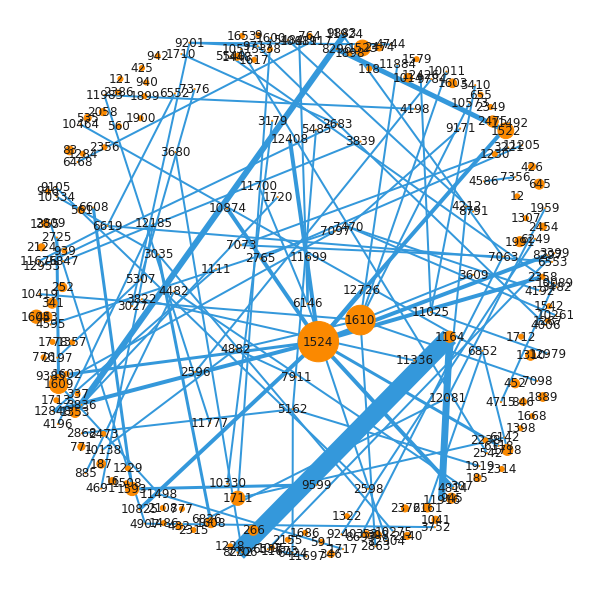

Resulting graph contains
- coauthor_nodes:  100
- coauthor_edges:  100

       Initial selected Authors


,author-index,author-name,number-papers
0,0,"(Bert) Hakkinen, Pertti J",1
2,2,"A, Chudnovsky",1
9,9,"A, Ziv",1
12,12,"AARON, SHAWN",1
15,15,"ANDERSON, MARK",1
...,...,...,...
13042,13042,"van Netten, C",1
13043,13043,"van Netten, Chris",4
13060,13060,"van den Bosch, Matilda",7
13077,13077,"vanNetten, C",2


In [1203]:
#--------------------------------------------------------------------------
# Visualise Co-Authors of Published Papers linked by Author ID (unique Name)
# Basic graph version to help understand data, not interactive
# colours: https://htmlcolorcodes.com/
#--------------------------------------------------------------------------
starttime = timeit.default_timer()

clr_edge = '#3498DB'
clr_node = '#FB8900'

G = nx.Graph()  

i=0
for index, row in nodes_sample.iterrows():
    # node_id, size_author
    G.add_node(row['author-1'], nodesize=row['weight']*5)
    i+=1

widths = []
for index, row in df_pairs_sample.iterrows():
    G.add_weighted_edges_from([(row['author-1'], row['author-2'], row['weight'])])
    widths.append(row['weight'])

# approx 5 mins to run this far
print('node rows     =',i)

plt.figure(figsize=(8,8))
options = {
    'edge_color': clr_edge,
    'node_color': clr_node,
    'with_labels': True,
    'font_weight': 'regular',
}

node_weight = 5
sizes = [G.nodes[n]['nodesize']*node_weight if len(G.nodes[n].keys())>0 else 1 for n in G]
#colors = [color_map[G.nodes[n]['group']] if len(G.nodes[n].keys())>0 else '#FFDEA2' for n in G]

"""
Using the spring layout : 
- k controls the distance between the nodes and varies between 0 and 1
- iterations is the number of times simulated annealing is run
- default k=0.1 and iterations=50

nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.25, iterations=50), **options)
"""

nx.draw(G, node_size=sizes, width=widths, pos=nx.spring_layout(G, k=1, iterations=50, seed=42), **options)
ax = plt.gca()
ax.collections[0].set_edgecolor(clr_node) 
plt.show();

# only show time taken if over 1 min
if (timeit.default_timer() - starttime)>60:
    print('\nTotal time is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes\n')

print('Resulting graph contains')
print('- coauthor_nodes: ', len(nodes_sample))
print('- coauthor_edges: ', len(df_pairs_sample))

nodes = df_node_author[['node_id','node_name','size_author']].copy()
nodes.columns = ['author-index','author-name','number-papers']

print('\n       Initial selected Authors')
nodes[nodes['author-index'].isin(select_author_index)]

In [1204]:
# what do Graph nodes look like
G.nodes

NodeView((9, 12, 16, 83, 118, 121, 185, 187, 252, 266, 308, 337, 338, 341, 346, 353, 425, 426, 432, 452, 453, 535, 560, 561, 591, 645, 655, 764, 771, 776, 777, 846, 939, 940, 942, 945, 946, 1014, 1041, 1095, 1164, 1228, 1229, 1230, 1267, 1284, 1307, 1310, 1322, 1353, 1355, 1357, 1398, 1448, 1486, 1508, 1522, 1523, 1524, 1542, 1579, 1593, 1602, 1603, 1604, 1608, 1609, 1610, 1617, 1653, 1668, 1686, 1711, 1712, 1713, 1718, 1778, 1889, 1898, 1899, 1900, 1991, 2058, 2108, 2124, 2140, 2155, 2161, 2238, 2314, 2315, 2349, 2356, 2358, 2376, 2386, 2454, 2473, 2474, 2475, 6146, 11700, 2863, 4882, 12848, 1111, 7911, 4814, 10874, 7470, 9171, 4595, 10138, 10261, 8297, 4192, 9599, 6608, 8252, 11025, 5410, 6852, 10464, 1600, 11205, 2765, 6142, 2725, 7063, 8693, 9883, 7073, 3221, 7097, 11498, 10573, 10011, 4586, 7356, 11884, 7098, 11673, 11697, 3609, 4482, 885, 11336, 3822, 307, 1717, 10419, 12408, 11924, 5162, 1919, 6424, 11983, 4198, 11777, 2868, 5485, 12081, 1959, 4212, 6826, 12185, 4196, 4691, 6249

### CREATE A GRAPH FUNCTION that we can re-use with different data

In [994]:
def network_graph(df_pairs, nodes_for_graph, sample_rows=100):
    G = nx.Graph()  

    df_pairs_graph = df_pairs[df_pairs['author-1'].isin(auth_index)][0:sample_rows]
    
    i=0
    for index, row in nodes_for_graph.iterrows():
        G.add_node(row['author-1'], nodesize=row['weight']*5)
        i=i+1

    widths = []
    for index, row in df_pairs_graph.iterrows():
        G.add_weighted_edges_from([(row['author-1'], row['author-2'], row['weight'])])
        widths.append(row['weight'])

    plt.figure(figsize=(5,5))
    options = {
        'edge_color': clr_edge,
        'node_color': clr_node,
        'with_labels': True,
        'font_weight': 'regular',
    }

    node_weight = 8
    #colors = [color_map[G.nodes[n]['group']] if len(G.nodes[n].keys())>0 else '#FFDEA2' for n in G]
    sizes = [G.nodes[n]['nodesize']*node_weight if len(G.nodes[n].keys())>0 else 1 for n in G]

    """
    Using the spring layout : 
    - k controls the distance between the nodes and varies between 0 and 1
    - iterations is the number of times simulated annealing is run
    - default k=0.1 and iterations=50

    nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.25, iterations=50), **options)
    """

    nx.draw(G, node_size=sizes, width=widths, pos=nx.spring_layout(G, k=1, iterations=50, seed=42), **options)
    ax = plt.gca()
    ax.collections[0].set_edgecolor(clr_node) 
    plt.show()
    
    return G

### CREATE NODE-HOPPING FUNCTIONS - to calculate N-Hops between Nodes, up to max hop (ie: cutoff)

In [1255]:
def node_hops(G, source_node, target_node, cutoff=3, show=False):
    n_hop = nx.single_source_shortest_path_length(G, source_node, cutoff=n_hop_max)
    
    # print output only if show = True
    if show==True:
        print(f'{cutoff}-hop nodes between ({source_node}, {target_node}) connected to {len(n_hop)} authors\n\n', n_hop,'\n')
    
    # return value of target node - if present, or None of not present
    return n_hop.get(target_node) if n_hop.get(target_node)!=None else 0;


# TEST IDs: 10944,1524,12408,6146,11700,11699
# node_hops(G_full, source_node=3822, target_node=2360

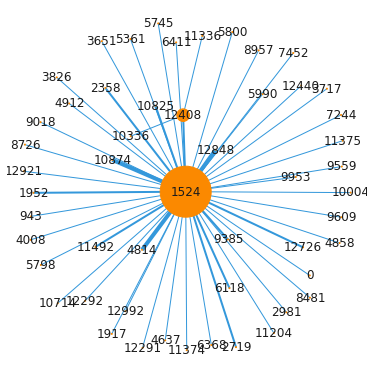

3-hop nodes between (10004, 1524) connected to 52 authors

 {10004: 0, 1524: 1, 4814: 2, 10874: 2, 12848: 2, 12408: 2, 2358: 2, 12726: 2, 11492: 2, 10825: 2, 9385: 2, 6118: 2, 1952: 2, 2719: 2, 2981: 2, 3651: 2, 3717: 2, 1917: 2, 0: 2, 943: 2, 3826: 2, 6411: 2, 5990: 2, 6368: 2, 7244: 2, 7452: 2, 5800: 2, 5798: 2, 4008: 2, 4637: 2, 4858: 2, 4912: 2, 5361: 2, 5745: 2, 8481: 2, 8726: 2, 8957: 2, 11204: 2, 11374: 2, 11375: 2, 12291: 2, 12292: 2, 12440: 2, 9018: 2, 9559: 2, 9609: 2, 9953: 2, 10714: 2, 12921: 2, 12992: 2, 10336: 3, 11336: 3} 



In [1227]:
# TEST Author Index's - maximum up
auth_index=(1524,10004,12408)  

n_hop_max = 3

G_auth = network_graph(df_pairs[df_pairs['author-1'].isin(auth_index)], \
                       nodes_for_graph[nodes_for_graph['author-1'].isin(auth_index)], sample_rows=200)

n_hop = node_hops(G_auth, source_node=auth_index[1], target_node=auth_index[0], cutoff=n_hop_max, show=True)

### quick check how single_source_shortest_path_length() works

In [1228]:
# quick check how single_source_shortest_path_length() works
source_node = 1524
n_hop_max = 3
n_hop = nx.single_source_shortest_path_length(G_full, source_node, cutoff=n_hop_max)
print(f'Source author : {source_node}\nconnected to  : {len(n_hop)} authors\nwithin        : {n_hop_max} hops','\n\n',n_hop)

Source author : 1524
connected to  : 50 authors
within        : 3 hops 

 {1524: 0, 4814: 1, 12848: 1, 12408: 1, 9385: 1, 2358: 1, 12726: 1, 3752: 1, 1952: 1, 1917: 1, 1716: 1, 817: 1, 2360: 1, 2719: 1, 4637: 1, 4858: 1, 3826: 1, 3651: 1, 5674: 1, 10004: 1, 9609: 1, 8726: 1, 8481: 1, 7452: 1, 7244: 1, 6411: 1, 5990: 1, 11374: 1, 12921: 1, 12793: 1, 11375: 1, 11204: 1, 10857: 1, 10714: 1, 5797: 2, 7122: 2, 1111: 2, 11336: 2, 10336: 2, 3822: 2, 461: 2, 10679: 2, 6121: 2, 2263: 2, 3415: 2, 10874: 3, 4286: 3, 2199: 3, 10400: 3, 4919: 3}


In [1229]:
# quick check how single_source_shortest_path_length() works
source_node = 9201
n_hop = nx.single_source_shortest_path_length(G_full, source_node, cutoff=n_hop_max)
print(f'Source author : {source_node}\nconnected to  : {len(n_hop)} authors\nwithin        : {n_hop_max} hops','\n\n',n_hop)

Source author : 9201
connected to  : 13 authors
within        : 3 hops 

 {9201: 0, 3027: 1, 3916: 1, 1617: 1, 1208: 1, 9589: 1, 2580: 1, 9189: 2, 2388: 2, 7463: 2, 5824: 2, 5015: 2, 2352: 2}


In [1215]:
# quick check how single_source_shortest_path_length() works
source_node = 2360
n_hop = nx.single_source_shortest_path_length(G_full, source_node, cutoff=n_hop_max)
print(f'Source author : {source_node}\nconnected to  : {len(n_hop)} authors\nwithin        : {n_hop_max} hops','\n\n',n_hop)

Source author : 2360
connected to  : 45 authors
within        : 3 hops 

 {2360: 0, 1524: 1, 4814: 2, 12848: 2, 12408: 2, 9385: 2, 2358: 2, 12726: 2, 3752: 2, 1952: 2, 1917: 2, 1716: 2, 817: 2, 2719: 2, 4637: 2, 4858: 2, 3826: 2, 3651: 2, 5674: 2, 10004: 2, 9609: 2, 8726: 2, 8481: 2, 7452: 2, 7244: 2, 6411: 2, 5990: 2, 11374: 2, 12921: 2, 12793: 2, 11375: 2, 11204: 2, 10857: 2, 10714: 2, 5797: 3, 7122: 3, 1111: 3, 11336: 3, 10336: 3, 3822: 3, 461: 3, 10679: 3, 6121: 3, 2263: 3, 3415: 3}


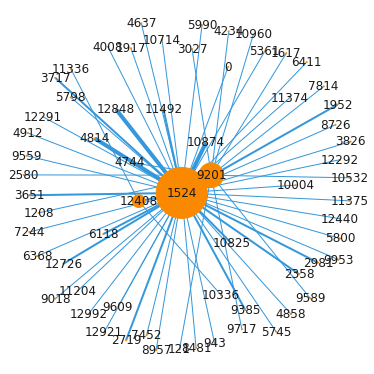

3-hop nodes between (9201, 2360) connected to 13 authors

 {9201: 0, 3027: 1, 4744: 1, 9717: 1, 7814: 1, 4234: 1, 9589: 1, 10532: 1, 10960: 1, 121: 1, 1208: 1, 1617: 1, 2580: 1} 

3-hop nodes between (1524, 12408) connected to 52 authors

 {1524: 0, 4814: 1, 10874: 1, 12848: 1, 12408: 1, 2358: 1, 12726: 1, 11492: 1, 10825: 1, 9385: 1, 6118: 1, 1952: 1, 2719: 1, 2981: 1, 3651: 1, 3717: 1, 1917: 1, 0: 1, 943: 1, 3826: 1, 6411: 1, 5990: 1, 6368: 1, 7244: 1, 7452: 1, 5800: 1, 5798: 1, 4008: 1, 4637: 1, 4858: 1, 4912: 1, 5361: 1, 5745: 1, 8481: 1, 8726: 1, 8957: 1, 11204: 1, 11374: 1, 11375: 1, 12291: 1, 12292: 1, 12440: 1, 10004: 1, 9018: 1, 9559: 1, 9609: 1, 9953: 1, 10714: 1, 12921: 1, 12992: 1, 10336: 2, 11336: 2} 



In [1230]:
auth_index=(9201,2360,1524,12408)  #,10004,12408,1524)  
n_hop_max = 3

G_auth = network_graph(df_pairs[df_pairs['author-1'].isin(auth_index)], \
                       nodes_for_graph[nodes_for_graph['author-1'].isin(auth_index)], sample_rows=200)

n_hop = node_hops(G_auth, source_node=auth_index[0], target_node=auth_index[1], cutoff=n_hop_max, show=True)
n_hop = node_hops(G_auth, source_node=auth_index[2], target_node=auth_index[3], cutoff=n_hop_max, show=True)
#n_hop = node_hops(G_auth, source_node=auth_index[3], cutoff=n_hop_max)

### VALIDATE RESULTS OF node_hops() function, with sample authors


In [1253]:
# VALIDATE RESULTS OF node_hops() function, with sample authors
# auth_index=(9201,2360,1524,12408) 
test = df_pairs[df_pairs['author-1'].isin([9201,12408])][['author-1','author-2']].copy()
test

,author-1,author-2
212,9201,3027
214,9201,4744
217,9201,9717
315,12408,10336
316,12408,11336
4371,9201,7814
4373,9201,4234
4380,9201,9589
4383,9201,10532
4384,9201,10960


In [1254]:
# ITERATE THROUGH ALL A1, A2 COMBINATIONS calling node_hops()
for A1, A2 in zip(test['author-1'],test['author-2']):
    #print(f'Check A1,A2 ({A1},{A2})')
    
    n_hop = node_hops(G_full, source_node=A1, target_node=A2, cutoff=n_hop_max, show=False)
    
    if n_hop==None:
        print(f'Check ({A1},{A2}),\tNO key    ({A2}),\tn-hop =', None if n_hop==None else n_hop)
    else:
        print(f'Check ({A1},{A2}),\tkey found ({A2}),\tn-hop =', None if n_hop==None else n_hop)

Check (9201,3027),	key found (3027),	n-hop = 1
Check (9201,4744),	key found (4744),	n-hop = 0
Check (9201,9717),	key found (9717),	n-hop = 0
Check (12408,10336),	key found (10336),	n-hop = 1
Check (12408,11336),	key found (11336),	n-hop = 1
Check (9201,7814),	key found (7814),	n-hop = 0
Check (9201,4234),	key found (4234),	n-hop = 0
Check (9201,9589),	key found (9589),	n-hop = 1
Check (9201,10532),	key found (10532),	n-hop = 0
Check (9201,10960),	key found (10960),	n-hop = 0
Check (9201,121),	key found (121),	n-hop = 0
Check (9201,1208),	key found (1208),	n-hop = 1
Check (9201,1617),	key found (1617),	n-hop = 1
Check (9201,2580),	key found (2580),	n-hop = 1


### CALCULATE N_HOPS FOR ALL AUTHORS IN OUR CITATIONS DATA
- for papers with max co-authors => 5
Use "apply" and "lambda" methods for all data rows

In [1274]:
pd.options.mode.chained_assignment = None

starttime = timeit.default_timer()

# run node_hops() function across all author-1, author-2 pairs
df_auth_hop = all_authors_merge.copy()
df_auth_hop['n_hop'] = df_auth_hop.apply(lambda X: node_hops(G_full, X['author-1'], X['author-2']), axis=1)

#if (timeit.default_timer() - starttime) > 60:
print('Time taken is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes\n')

# Time taken is : 68.61 seconds / 1.14 minutes for 1.1 million auth-pair rows (1,166,628)
df_auth_hop.head(10)

Time taken is : 66.57 seconds / 1.11 minutes



,author-1,author-2,auth-pair,auth-pair-rev,weight_all_years,weight_2_years,weight_5_years,weight_10_years,n_hop
0,11038,9822,"11038,9822","9822,11038",NaN,NaN,NaN,NaN,0
1,11038,5018,"11038,5018","5018,11038",NaN,NaN,NaN,NaN,0
2,11038,10371,"11038,10371","10371,11038",NaN,NaN,NaN,NaN,0
3,11038,5101,"11038,5101","5101,11038",NaN,NaN,NaN,NaN,0
4,11038,3916,"11038,3916","3916,11038",NaN,NaN,NaN,NaN,0
5,11038,4197,"11038,4197","4197,11038",NaN,NaN,NaN,NaN,0
6,11038,4368,"11038,4368","4368,11038",NaN,NaN,NaN,NaN,0
7,11038,1524,"11038,1524","1524,11038",NaN,NaN,NaN,NaN,0
8,11038,11916,"11038,11916","11916,11038",NaN,NaN,NaN,NaN,0
9,11038,1609,"11038,1609","1609,11038",NaN,NaN,NaN,NaN,0


### Initial results with n_hop for all A1,A2 pair rows - ignore the NaN values, will clean up next step

In [1275]:
# Initial data with n_hop results for all A1,A2 pair rows - ignore the NaN values, will clean up next step
df_auth_hop

,author-1,author-2,auth-pair,auth-pair-rev,weight_all_years,weight_2_years,weight_5_years,weight_10_years,n_hop
0,11038,9822,"11038,9822","9822,11038",NaN,NaN,NaN,NaN,0
1,11038,5018,"11038,5018","5018,11038",NaN,NaN,NaN,NaN,0
2,11038,10371,"11038,10371","10371,11038",NaN,NaN,NaN,NaN,0
3,11038,5101,"11038,5101","5101,11038",NaN,NaN,NaN,NaN,0
4,11038,3916,"11038,3916","3916,11038",NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
1166634,9366,6091,"9366,6091","6091,9366",NaN,NaN,NaN,NaN,0
1166635,9366,4457,"9366,4457","4457,9366",NaN,NaN,NaN,NaN,0
1166636,4595,6091,"4595,6091","6091,4595",NaN,NaN,NaN,NaN,0
1166637,4595,4457,"4595,4457","4457,4595",NaN,NaN,NaN,NaN,0


### VIEW N-HOP RESULTS FOR ALL A1,A2 PAIRS - show only where N_hop is not 0

### DATA IS NOW READY for linking to Topics, and then Modelling

In [1271]:
# VIEW N-HOP RESULTS FOR ALL A1,A2 PAIRS - show only where N_hop is not 0
df_auth_hop = df_auth_hop[['auth-pair','author-1','author-2','weight_all_years','weight_2_years','weight_5_years','weight_10_years','n_hop']]

# set NAN values to 0
df_auth_hop = df_auth_hop.fillna(0)

# fix float values to integer only (small numbers only)
df_auth_hop[['weight_all_years','weight_2_years','weight_5_years','weight_10_years']] = df_auth_hop[['weight_all_years','weight_2_years','weight_5_years','weight_10_years']].astype(int)

print(f'       Total Author A1,A2 pair rows = {len(df_auth_hop)}\n       Sample rows ({len(df_auth_hop[df_auth_hop["n_hop"]!=0])}) where n_hop is not 0 (ie: 1 to 3) \n')

# view results - check weights are integers, not floats too 
df_auth_hop[df_auth_hop['n_hop']!=0]

       Total Author A1,A2 pair rows = 1166628
       Sample rows (3659) where n_hop is not 0 (ie: 1 to 3) 



,auth-pair,author-1,author-2,weight_all_years,weight_2_years,weight_5_years,weight_10_years,n_hop
524,"11038,1211",11038,1211,1,1,1,1,1
3576,"5018,3625",5018,3625,1,1,1,1,1
6624,"5101,10693",5101,10693,1,1,1,1,1
7011,"5101,1517",5101,1517,1,1,1,1,1
7062,"5101,1888",5101,1888,0,0,0,0,2
...,...,...,...,...,...,...,...,...
1164883,"4643,4359",4643,4359,0,0,0,0,2
1165050,"10332,6275",10332,6275,0,0,0,0,3
1165059,"10332,1142",10332,1142,0,0,0,0,2
1165107,"8934,8935",8934,8935,0,0,0,0,2


In [1272]:
# Quick check all weight types are integer, not float
df_auth_hop.dtypes

auth-pair           object
author-1             int64
author-2             int64
weight_all_years     int64
weight_2_years       int64
weight_5_years       int64
weight_10_years      int64
n_hop                int64
dtype: object

### Centrality
 - In degree
 - Out degree
 - Betweeness
 - Closeness
 
### Degree centrality
Degree centrality is the simplest centrality measure to compute. A node's degree is simply the number of connections the node has. A node with 5 connections would have a degree centrality of 1 whereas a node with 1 connection would have a degree centrality of 1. Degree centrality can be normalized in some applications to find relative degree centrality of nodes.

For degree centrality, higher values mean that the node is more central. There are however exceptions to this rule of thumb. Although a node may be connected to many other nodes, it may also be far off on the edge of the network.

### Betweennes centrality
Betweenness centrality is important in many cases in network analysis. As above exmaple tells, a higher degree centrality will not always yield to higher betweenness centrality. Betweenness centrality is an important metric, as it discovers nodes connecting many dispatched group of nodes to one another.

For betweenness centrality, higher values mean that the node is connecting higher number of nodes to one another. In co-authorship networks this could be the fact that authors having higher betweenness centrality have diverse set of interests and possibly interacts and experiments with diverse set of fields. These people are very important in fight against covid19.

https://cs.brynmawr.edu/Courses/cs380/spring2013/section02/slides/05_Centrality.pdf

https://www.kaggle.com/bkoseoglu/co-authorship-network-analysis


In [1282]:
cent_measure = nx.algorithms.degree_centrality(G)       # Notice the 3 airports from which all of our 100 rows of data originates
dens_measure = nx.density(G)                            # Average edge density of the Graphs

avg_short_path = nx.average_shortest_path_length(G)     # Average shortest path length for ALL paths in the Graph
avg_degree_connect = nx.average_degree_connectivity(G)  # For a node of degree k - What is the average of its neighbours' degree?

In [1284]:
#print('degree centrality    :', cent_measure)
print('edge density                :', dens_measure)
print('average shortest path       :', avg_short_path)
print('average degree connectivity :', avg_degree_connect)

edge density                : 0.4
average shortest path       : 2.0
average degree connectivity : {1: 2.0, 2: 1.6666666666666667}


In [1285]:
deg_measure = nx.degree(G) 
cent_measure = nx.degree_centrality(G) 
bet_measure = nx.betweenness_centrality(G)

In [1288]:
# nx.degree(G) 
print('degree(G)\n',deg_measure)

degree(G)
 [(0, 1), (1, 2), (2, 2), (3, 2), (4, 1)]


In [1287]:
# nx.degree_centrality(G) 
print('degree_centrality(G) \n',cent_measure)

degree_centrality(G) 
 {0: 0.25, 1: 0.5, 2: 0.5, 3: 0.5, 4: 0.25}


In [1278]:
# nx.betweenness_centrality(G)
print('betweenness_centrality(G)\n',bet_measure)

betweenness_centrality(G)
 {13028: 0.0009641873278236914, 2161: 0.0, 11205: 0.002754820936639118, 6146: 0.012258953168044076, 12979: 0.004820936639118457, 7376: 0.0009641873278236914, 4198: 0.004132231404958677, 1547: 0.0012396694214876032, 11917: 0.005096418732782369, 5410: 0.02258953168044077, 9201: 0.004820936639118457, 9824: 0.003168044077134986, 12187: 0.00041322314049586776, 6039: 0.001515151515151515, 1718: 0.003994490358126722, 6619: 0.001790633608815427, 1717: 0.001790633608815427, 11733: 0.0, 9168: 0.0012396694214876032, 1524: 0.008126721763085399, 1711: 0.0001377410468319559, 1610: 0.003168044077134986, 4642: 0.0, 5162: 0.002892561983471074, 3794: 0.0012396694214876032, 8252: 0.0, 12812: 0.0, 11916: 0.0001377410468319559, 1617: 0.0, 10945: 0.0, 6620: 0.0, 5326: 0.0, 7370: 0.0001377410468319559, 3714: 0.0, 6454: 0.0, 6291: 0.0002754820936639118, 2654: 0.0, 2569: 0.0, 1734: 0.0, 12707: 0.0, 11136: 0.0002754820936639118, 2863: 0.0012396694214876032, 3398: 0.0, 11023: 0.00247933

In [ ]:
""" WEBSITES THAT WERE HELPFUL FOR THIS PROGRAM

https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
https://stackoverflow.com/questions/493819/why-is-it-string-joinlist-instead-of-list-joinstring

https://stackoverflow.com/questions/16228248/how-can-i-get-list-of-values-from-dict
"""